**BOOK: GENERATIVE DEEP LEARNING O'REILLY**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

## Utility Functions

In [2]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [3]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## Parameters

In [4]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## Getting the data

In [5]:
%%capture
!unzip /content/drive/MyDrive/IA/Data/lego_bricks.zip -d lego_bricks

In [6]:
train_data = utils.image_dataset_from_directory(
    "lego_bricks",
    labels=None,
    color_mode='grayscale',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

Found 40000 files.


In [7]:
def preprocess(image):
    """
    Normalize and reshape the images
    """
    image = (tf.cast(image, 'float32') - 127.5) / 127.5
    return image

train = train_data.map(lambda x: preprocess(x))

In [8]:
train_sample = sample_batch(train)

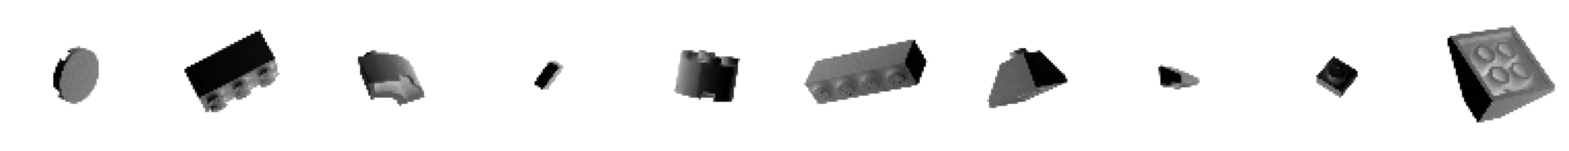

In [9]:
display(train_sample)

## Building the GAN

- The goal of the discriminator is to predict if an image is real of fake

In [10]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same",
                  use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same',
                  use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same',
                  use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding='valid',
                  use_bias=False, activation='sigmoid')(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

- The input to the generator will be a vector (n = 100) drawn from a multivariate standard normal distribution. The output is an image of the same size as an image in the original training data

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
# This last Conv layer uses a tanh to transform the output to the
# range [-1, 1] to match the original image domain
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 1)           │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,576,577 (13.64 MB)

 Trainable params: 3,574,657 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Training the GAN

In [12]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [13]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [14]:
if LOAD_MODEL:
    dcgan.load_weights('dcgan_weights.h5')

In [15]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    )
)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=".weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="generated_img_%03d.png" % (epoch),
        )

Epoch 1/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - d_acc: 0.8667 - d_fake_acc: 0.8671 - d_loss: 0.1908 - d_real_acc: 0.8663 - g_acc: 0.1329 - g_loss: 4.7530
Saved to generated_img_000.png


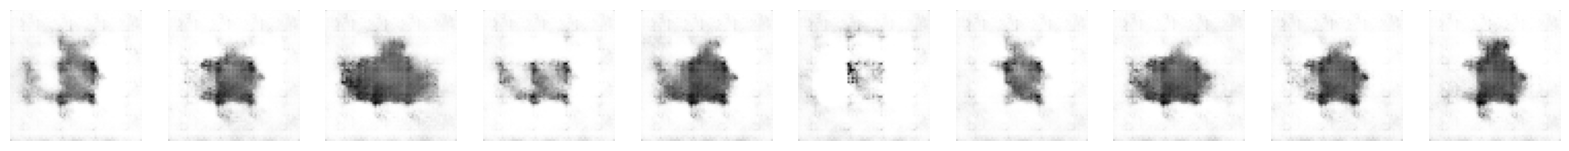

313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 305ms/step - d_acc: 0.8667 - d_fake_acc: 0.8671 - d_loss: 0.1909 - d_real_acc: 0.8663 - g_acc: 0.1329 - g_loss: 4.7517
Epoch 2/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - d_acc: 0.9050 - d_fake_acc: 0.9104 - d_loss: 0.0159 - d_real_acc: 0.8996 - g_acc: 0.0896 - g_loss: 5.2951
Saved to generated_img_001.png


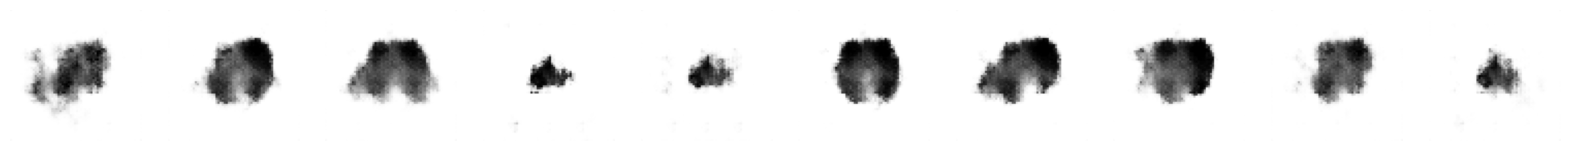

313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 246ms/step - d_acc: 0.9050 - d_fake_acc: 0.9104 - d_loss: 0.0157 - d_real_acc: 0.8996 - g_acc: 0.0896 - g_loss: 5.2967
Epoch 3/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - d_acc: 0.8790 - d_fake_acc: 0.8846 - d_loss: 0.1449 - d_real_acc: 0.8735 - g_acc: 0.1154 - g_loss: 5.4908
Saved to generated_img_002.png


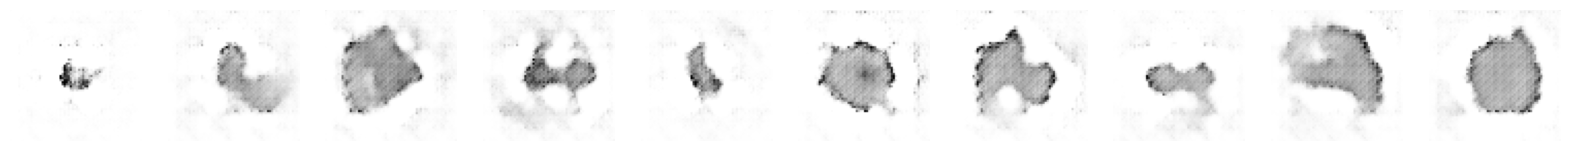

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 248ms/step - d_acc: 0.8790 - d_fake_acc: 0.8846 - d_loss: 0.1448 - d_real_acc: 0.8735 - g_acc: 0.1154 - g_loss: 5.4890
Epoch 4/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_acc: 0.8906 - d_fake_acc: 0.8898 - d_loss: 0.0769 - d_real_acc: 0.8914 - g_acc: 0.1102 - g_loss: 4.5121
Saved to generated_img_003.png


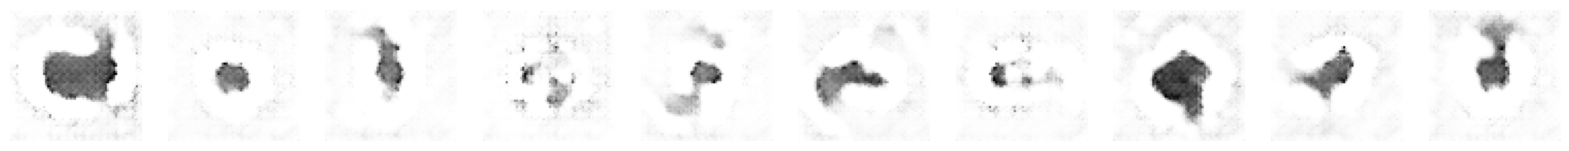

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 273ms/step - d_acc: 0.8906 - d_fake_acc: 0.8898 - d_loss: 0.0769 - d_real_acc: 0.8914 - g_acc: 0.1102 - g_loss: 4.5114
Epoch 5/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - d_acc: 0.8537 - d_fake_acc: 0.8505 - d_loss: 0.2286 - d_real_acc: 0.8568 - g_acc: 0.1495 - g_loss: 4.0566
Saved to generated_img_004.png


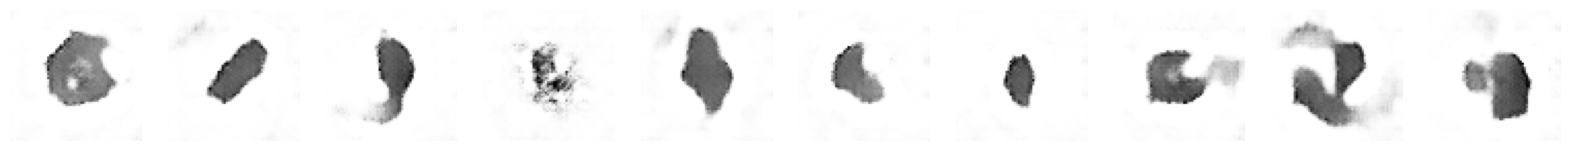

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - d_acc: 0.8537 - d_fake_acc: 0.8506 - d_loss: 0.2285 - d_real_acc: 0.8568 - g_acc: 0.1494 - g_loss: 4.0561
Epoch 6/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - d_acc: 0.8871 - d_fake_acc: 0.8875 - d_loss: 0.1112 - d_real_acc: 0.8867 - g_acc: 0.1125 - g_loss: 4.0854
Saved to generated_img_005.png


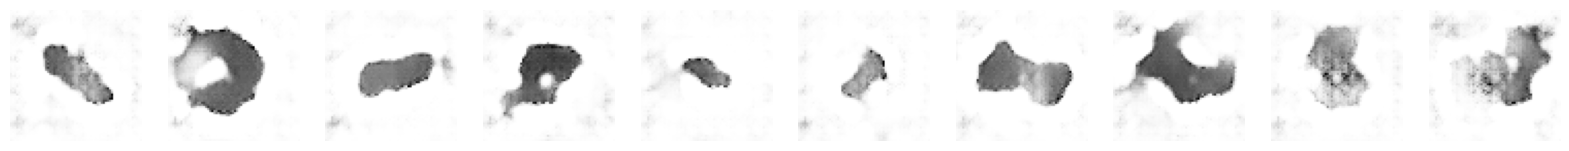

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - d_acc: 0.8871 - d_fake_acc: 0.8875 - d_loss: 0.1112 - d_real_acc: 0.8867 - g_acc: 0.1125 - g_loss: 4.0854
Epoch 7/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - d_acc: 0.8893 - d_fake_acc: 0.8887 - d_loss: 0.1060 - d_real_acc: 0.8899 - g_acc: 0.1113 - g_loss: 4.3946
Saved to generated_img_006.png


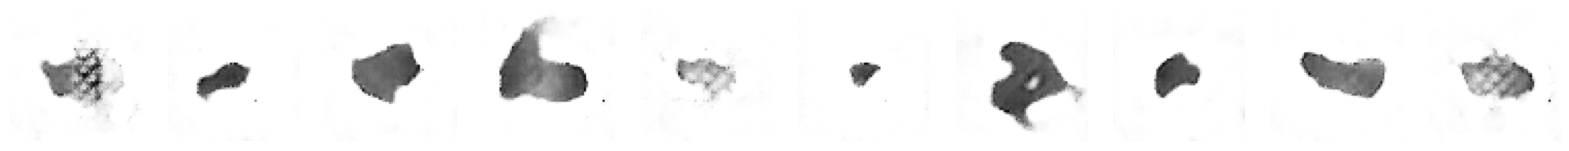

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - d_acc: 0.8893 - d_fake_acc: 0.8887 - d_loss: 0.1061 - d_real_acc: 0.8899 - g_acc: 0.1113 - g_loss: 4.3943
Epoch 8/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - d_acc: 0.8932 - d_fake_acc: 0.8996 - d_loss: 0.0784 - d_real_acc: 0.8867 - g_acc: 0.1004 - g_loss: 4.4406
Saved to generated_img_007.png


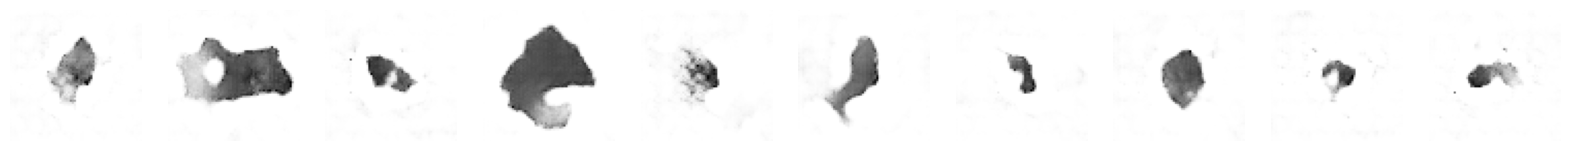

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - d_acc: 0.8932 - d_fake_acc: 0.8996 - d_loss: 0.0785 - d_real_acc: 0.8867 - g_acc: 0.1004 - g_loss: 4.4404
Epoch 9/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - d_acc: 0.8915 - d_fake_acc: 0.8927 - d_loss: 0.0877 - d_real_acc: 0.8903 - g_acc: 0.1073 - g_loss: 4.3822
Saved to generated_img_008.png


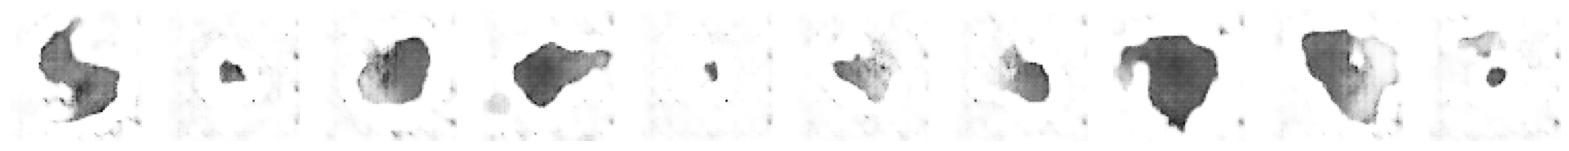

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 259ms/step - d_acc: 0.8915 - d_fake_acc: 0.8927 - d_loss: 0.0877 - d_real_acc: 0.8903 - g_acc: 0.1073 - g_loss: 4.3825
Epoch 10/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - d_acc: 0.8946 - d_fake_acc: 0.8930 - d_loss: 0.1053 - d_real_acc: 0.8962 - g_acc: 0.1070 - g_loss: 4.6042
Saved to generated_img_009.png


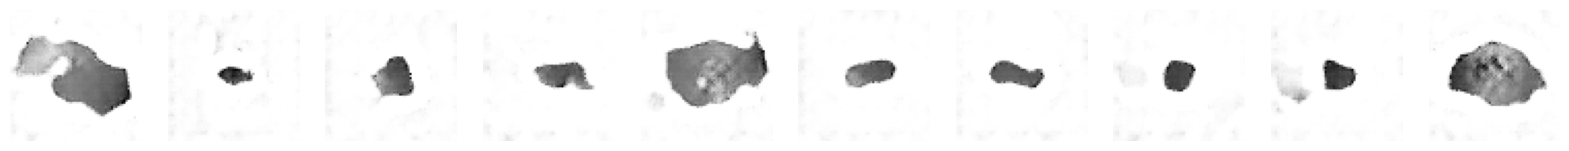

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - d_acc: 0.8946 - d_fake_acc: 0.8930 - d_loss: 0.1052 - d_real_acc: 0.8962 - g_acc: 0.1070 - g_loss: 4.6049
Epoch 11/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - d_acc: 0.9098 - d_fake_acc: 0.9107 - d_loss: 0.0429 - d_real_acc: 0.9088 - g_acc: 0.0893 - g_loss: 4.7638
Saved to generated_img_010.png


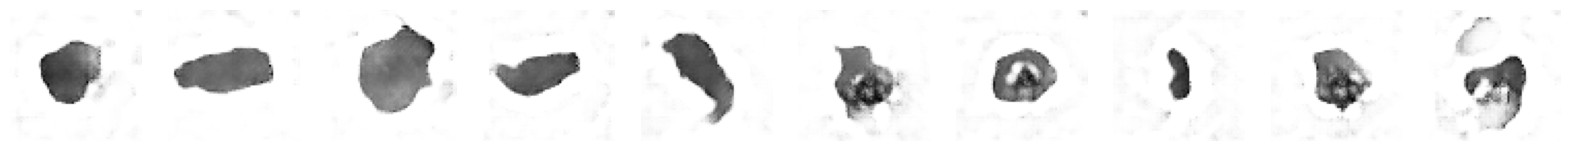

313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 256ms/step - d_acc: 0.9097 - d_fake_acc: 0.9107 - d_loss: 0.0430 - d_real_acc: 0.9088 - g_acc: 0.0893 - g_loss: 4.7633
Epoch 12/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - d_acc: 0.9110 - d_fake_acc: 0.9113 - d_loss: 0.0182 - d_real_acc: 0.9107 - g_acc: 0.0887 - g_loss: 5.1006
Saved to generated_img_011.png


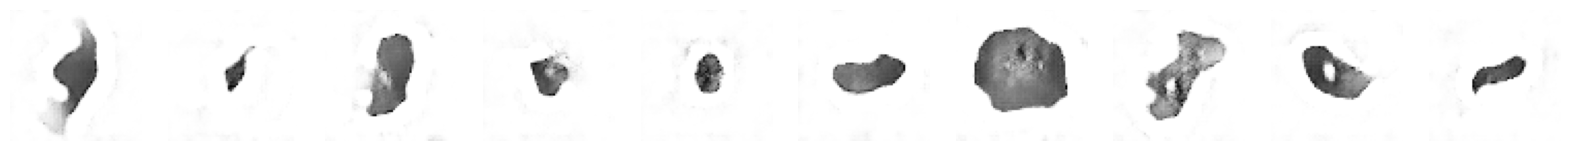

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - d_acc: 0.9110 - d_fake_acc: 0.9113 - d_loss: 0.0180 - d_real_acc: 0.9108 - g_acc: 0.0887 - g_loss: 5.1011
Epoch 13/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - d_acc: 0.8631 - d_fake_acc: 0.8608 - d_loss: 0.2766 - d_real_acc: 0.8655 - g_acc: 0.1392 - g_loss: 4.8420
Saved to generated_img_012.png


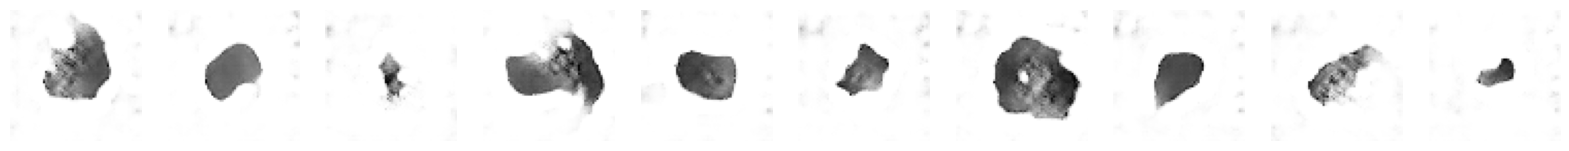

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - d_acc: 0.8633 - d_fake_acc: 0.8609 - d_loss: 0.2760 - d_real_acc: 0.8656 - g_acc: 0.1391 - g_loss: 4.8419
Epoch 14/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - d_acc: 0.9183 - d_fake_acc: 0.9153 - d_loss: -0.0035 - d_real_acc: 0.9212 - g_acc: 0.0847 - g_loss: 5.1612
Saved to generated_img_013.png


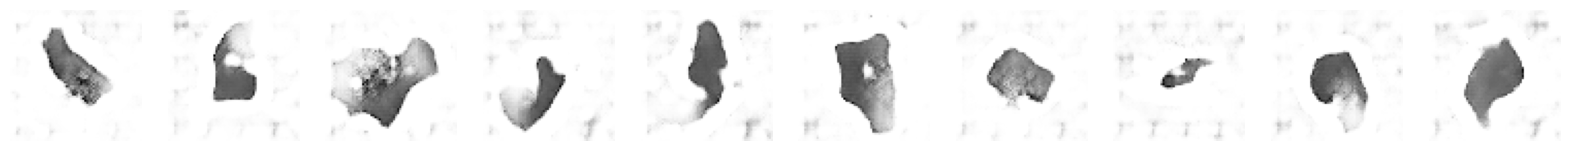

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 262ms/step - d_acc: 0.9183 - d_fake_acc: 0.9153 - d_loss: -0.0035 - d_real_acc: 0.9212 - g_acc: 0.0847 - g_loss: 5.1614
Epoch 15/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - d_acc: 0.9459 - d_fake_acc: 0.9465 - d_loss: -0.0997 - d_real_acc: 0.9453 - g_acc: 0.0535 - g_loss: 6.0228
Saved to generated_img_014.png


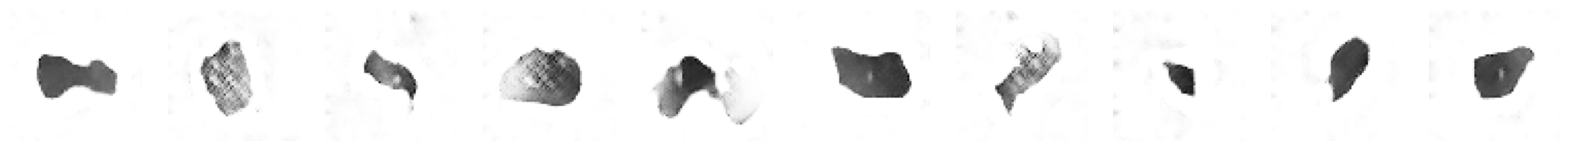

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 261ms/step - d_acc: 0.9459 - d_fake_acc: 0.9465 - d_loss: -0.0996 - d_real_acc: 0.9453 - g_acc: 0.0535 - g_loss: 6.0224
Epoch 16/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - d_acc: 0.9235 - d_fake_acc: 0.9236 - d_loss: 0.0162 - d_real_acc: 0.9233 - g_acc: 0.0764 - g_loss: 5.9782
Saved to generated_img_015.png


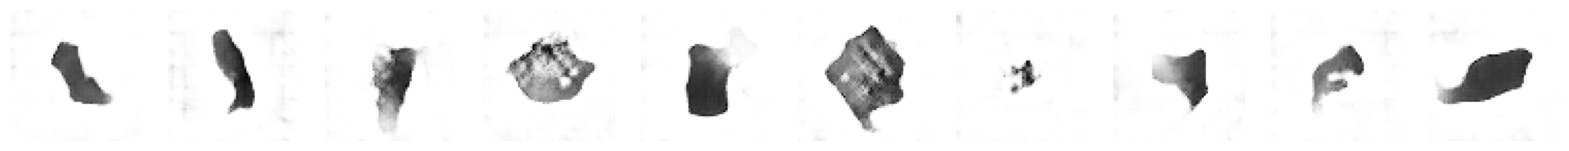

313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 266ms/step - d_acc: 0.9235 - d_fake_acc: 0.9237 - d_loss: 0.0161 - d_real_acc: 0.9233 - g_acc: 0.0763 - g_loss: 5.9770
Epoch 17/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - d_acc: 0.9124 - d_fake_acc: 0.9128 - d_loss: -0.0191 - d_real_acc: 0.9121 - g_acc: 0.0872 - g_loss: 5.9958
Saved to generated_img_016.png


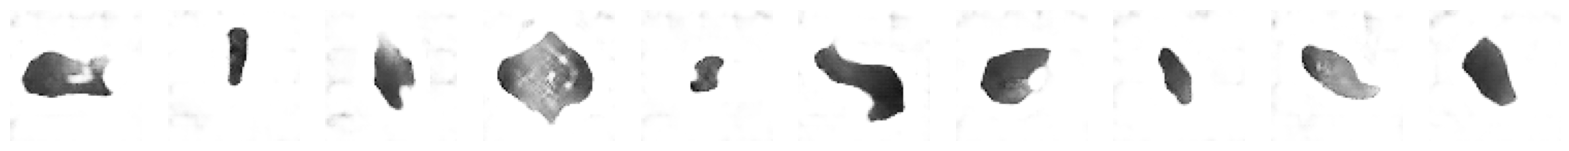

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 268ms/step - d_acc: 0.9124 - d_fake_acc: 0.9128 - d_loss: -0.0192 - d_real_acc: 0.9121 - g_acc: 0.0872 - g_loss: 5.9957
Epoch 18/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - d_acc: 0.9325 - d_fake_acc: 0.9334 - d_loss: -0.0780 - d_real_acc: 0.9315 - g_acc: 0.0666 - g_loss: 6.2456
Saved to generated_img_017.png


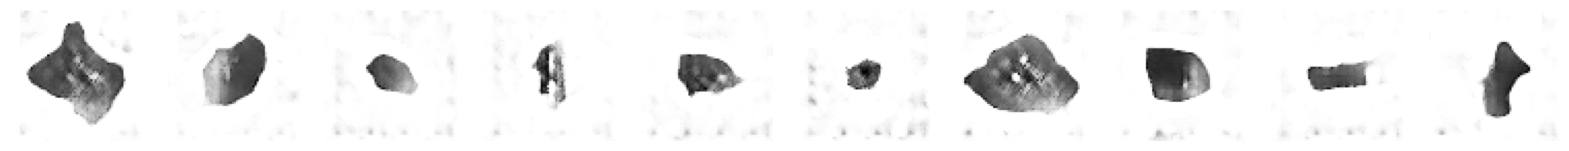

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 270ms/step - d_acc: 0.9325 - d_fake_acc: 0.9334 - d_loss: -0.0780 - d_real_acc: 0.9315 - g_acc: 0.0666 - g_loss: 6.2453
Epoch 19/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - d_acc: 0.8723 - d_fake_acc: 0.8721 - d_loss: 0.0696 - d_real_acc: 0.8725 - g_acc: 0.1279 - g_loss: 5.6927
Saved to generated_img_018.png


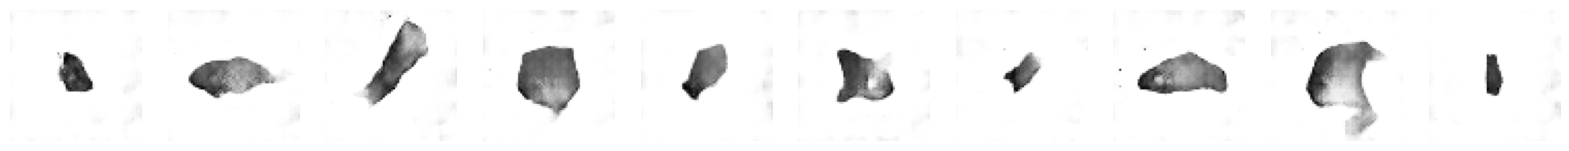

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 266ms/step - d_acc: 0.8722 - d_fake_acc: 0.8720 - d_loss: 0.0699 - d_real_acc: 0.8724 - g_acc: 0.1280 - g_loss: 5.6908
Epoch 20/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - d_acc: 0.9529 - d_fake_acc: 0.9523 - d_loss: -0.1625 - d_real_acc: 0.9535 - g_acc: 0.0477 - g_loss: 6.3665
Saved to generated_img_019.png


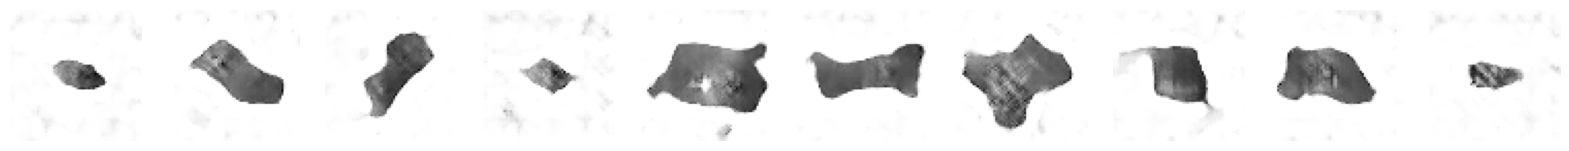

313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - d_acc: 0.9529 - d_fake_acc: 0.9523 - d_loss: -0.1623 - d_real_acc: 0.9535 - g_acc: 0.0477 - g_loss: 6.3670
Epoch 21/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - d_acc: 0.9205 - d_fake_acc: 0.9160 - d_loss: -0.0215 - d_real_acc: 0.9251 - g_acc: 0.0840 - g_loss: 6.3556
Saved to generated_img_020.png


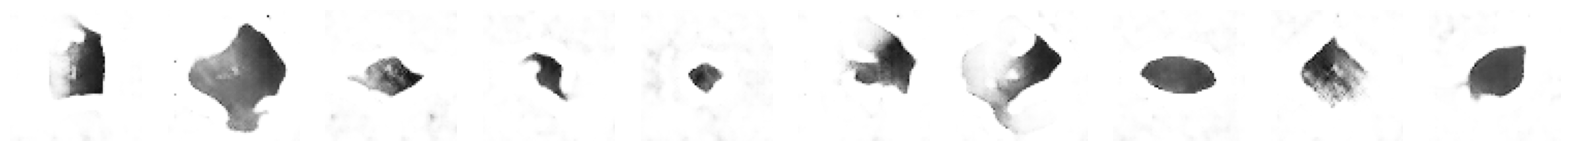

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - d_acc: 0.9205 - d_fake_acc: 0.9160 - d_loss: -0.0216 - d_real_acc: 0.9251 - g_acc: 0.0840 - g_loss: 6.3561
Epoch 22/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - d_acc: 0.9372 - d_fake_acc: 0.9391 - d_loss: -0.0993 - d_real_acc: 0.9353 - g_acc: 0.0609 - g_loss: 6.9947
Saved to generated_img_021.png


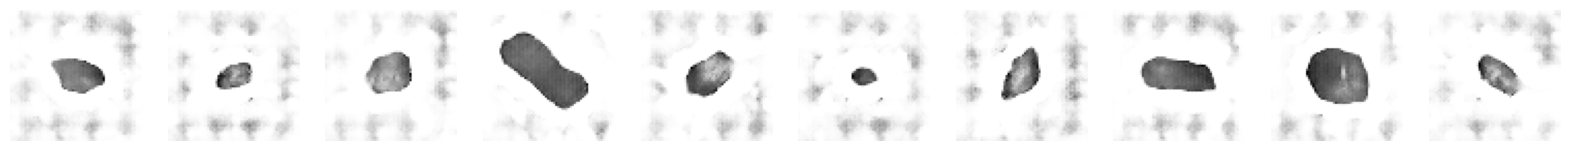

313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 267ms/step - d_acc: 0.9372 - d_fake_acc: 0.9391 - d_loss: -0.0993 - d_real_acc: 0.9354 - g_acc: 0.0609 - g_loss: 6.9956
Epoch 23/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - d_acc: 0.9203 - d_fake_acc: 0.9183 - d_loss: -0.0299 - d_real_acc: 0.9223 - g_acc: 0.0817 - g_loss: 6.0029
Saved to generated_img_022.png


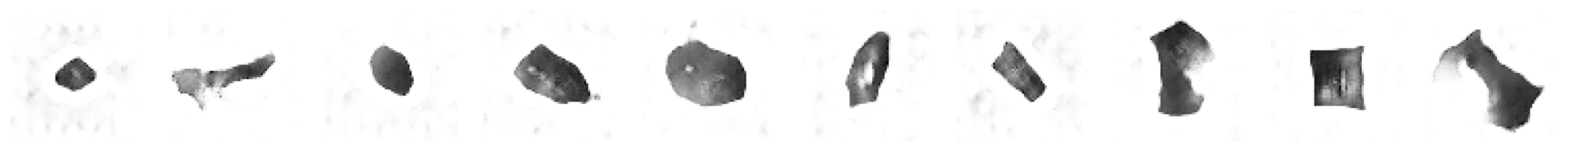

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 269ms/step - d_acc: 0.9204 - d_fake_acc: 0.9184 - d_loss: -0.0301 - d_real_acc: 0.9223 - g_acc: 0.0816 - g_loss: 6.0047
Epoch 24/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_acc: 0.9480 - d_fake_acc: 0.9479 - d_loss: -0.1405 - d_real_acc: 0.9481 - g_acc: 0.0521 - g_loss: 7.3338
Saved to generated_img_023.png


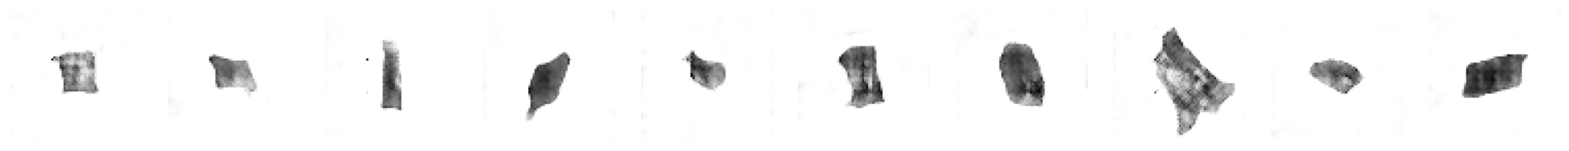

313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 272ms/step - d_acc: 0.9479 - d_fake_acc: 0.9479 - d_loss: -0.1404 - d_real_acc: 0.9480 - g_acc: 0.0521 - g_loss: 7.3330
Epoch 25/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - d_acc: 0.9105 - d_fake_acc: 0.9094 - d_loss: 0.0492 - d_real_acc: 0.9117 - g_acc: 0.0906 - g_loss: 6.2365
Saved to generated_img_024.png


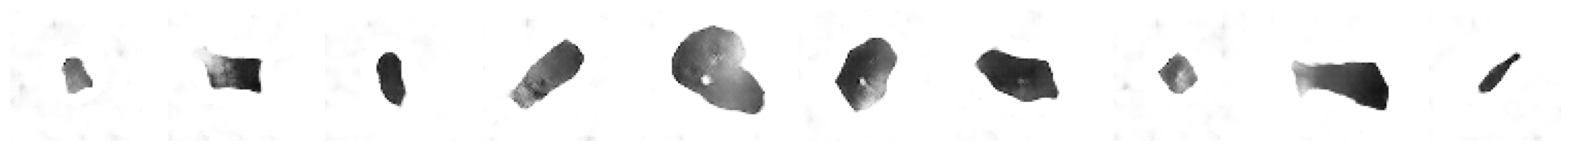

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 271ms/step - d_acc: 0.9106 - d_fake_acc: 0.9095 - d_loss: 0.0486 - d_real_acc: 0.9118 - g_acc: 0.0905 - g_loss: 6.2391
Epoch 26/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - d_acc: 0.9365 - d_fake_acc: 0.9352 - d_loss: -0.1050 - d_real_acc: 0.9378 - g_acc: 0.0648 - g_loss: 8.0049
Saved to generated_img_025.png


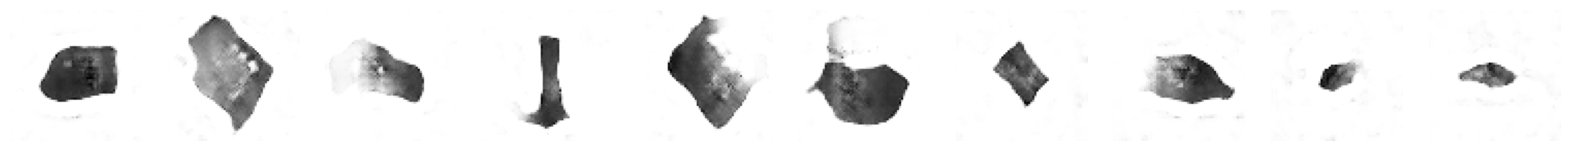

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 271ms/step - d_acc: 0.9365 - d_fake_acc: 0.9352 - d_loss: -0.1049 - d_real_acc: 0.9378 - g_acc: 0.0648 - g_loss: 8.0033
Epoch 27/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - d_acc: 0.9320 - d_fake_acc: 0.9319 - d_loss: -0.0459 - d_real_acc: 0.9321 - g_acc: 0.0681 - g_loss: 6.8549
Saved to generated_img_026.png


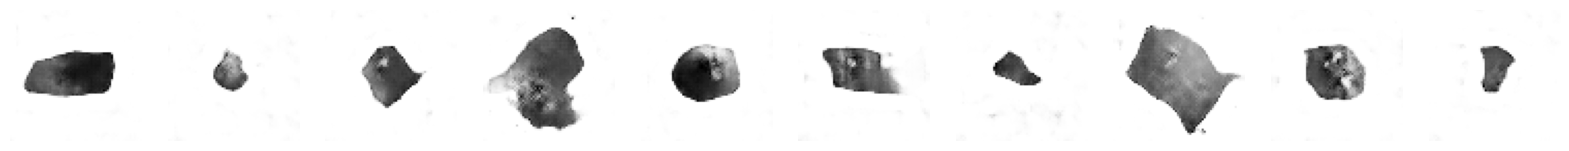

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 271ms/step - d_acc: 0.9320 - d_fake_acc: 0.9320 - d_loss: -0.0462 - d_real_acc: 0.9321 - g_acc: 0.0680 - g_loss: 6.8564
Epoch 28/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - d_acc: 0.9281 - d_fake_acc: 0.9306 - d_loss: -0.0380 - d_real_acc: 0.9256 - g_acc: 0.0694 - g_loss: 7.4460
Saved to generated_img_027.png


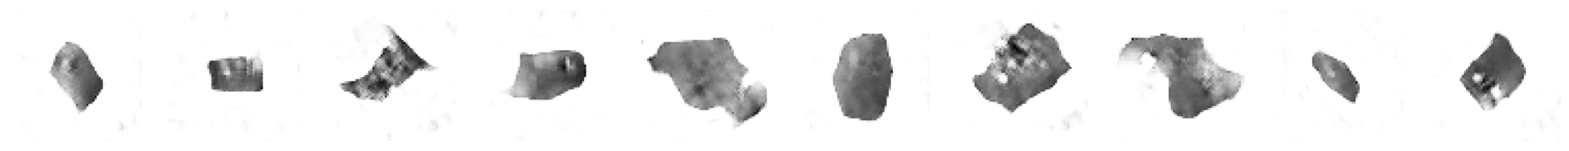

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 269ms/step - d_acc: 0.9281 - d_fake_acc: 0.9306 - d_loss: -0.0381 - d_real_acc: 0.9257 - g_acc: 0.0694 - g_loss: 7.4459
Epoch 29/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - d_acc: 0.9660 - d_fake_acc: 0.9667 - d_loss: -0.2875 - d_real_acc: 0.9653 - g_acc: 0.0333 - g_loss: 8.7824
Saved to generated_img_028.png


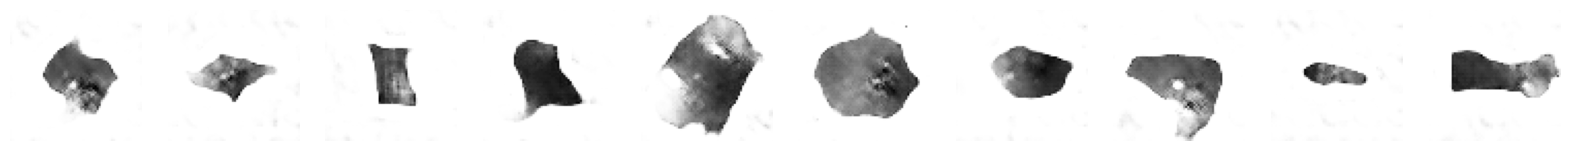

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 268ms/step - d_acc: 0.9660 - d_fake_acc: 0.9667 - d_loss: -0.2874 - d_real_acc: 0.9653 - g_acc: 0.0333 - g_loss: 8.7825
Epoch 30/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - d_acc: 0.9428 - d_fake_acc: 0.9427 - d_loss: -0.1124 - d_real_acc: 0.9429 - g_acc: 0.0573 - g_loss: 8.3086
Saved to generated_img_029.png


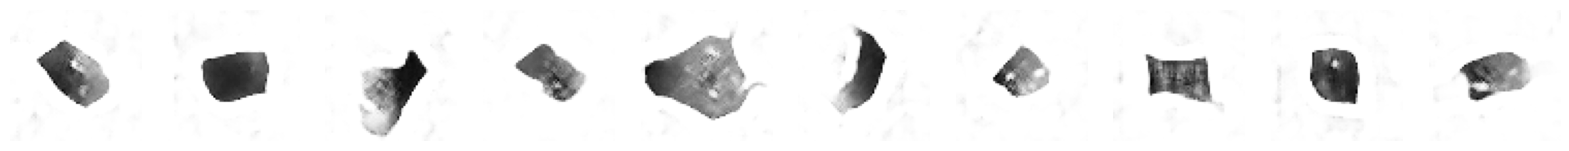

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 265ms/step - d_acc: 0.9428 - d_fake_acc: 0.9428 - d_loss: -0.1125 - d_real_acc: 0.9429 - g_acc: 0.0572 - g_loss: 8.3079
Epoch 31/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_acc: 0.9291 - d_fake_acc: 0.9070 - d_loss: 0.2155 - d_real_acc: 0.9513 - g_acc: 0.0930 - g_loss: 8.2133
Saved to generated_img_030.png


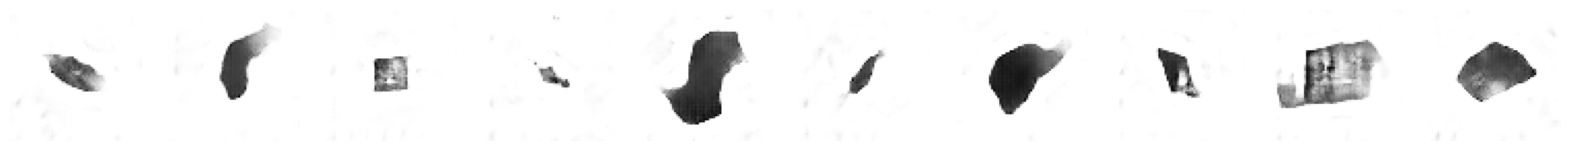

313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 272ms/step - d_acc: 0.9291 - d_fake_acc: 0.9069 - d_loss: 0.2157 - d_real_acc: 0.9513 - g_acc: 0.0931 - g_loss: 8.2117
Epoch 32/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_acc: 0.9244 - d_fake_acc: 0.9300 - d_loss: -0.0959 - d_real_acc: 0.9188 - g_acc: 0.0700 - g_loss: 8.1325
Saved to generated_img_031.png


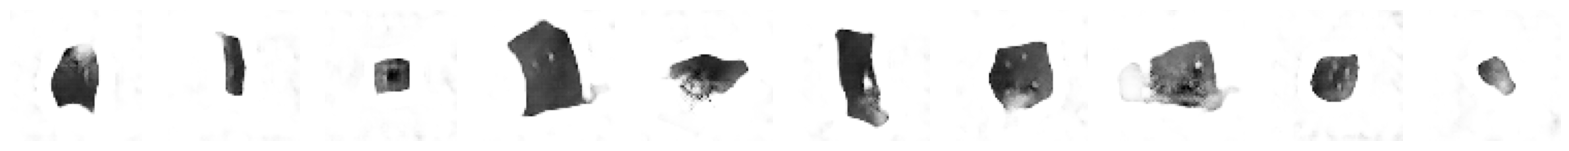

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 273ms/step - d_acc: 0.9245 - d_fake_acc: 0.9301 - d_loss: -0.0964 - d_real_acc: 0.9189 - g_acc: 0.0699 - g_loss: 8.1339
Epoch 33/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - d_acc: 0.9095 - d_fake_acc: 0.9107 - d_loss: 0.0060 - d_real_acc: 0.9083 - g_acc: 0.0893 - g_loss: 7.9427
Saved to generated_img_032.png


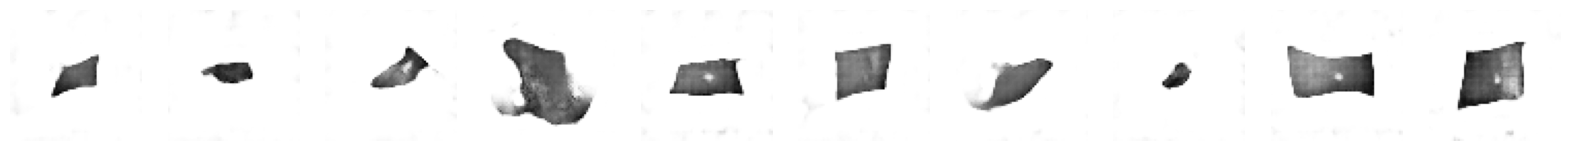

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 272ms/step - d_acc: 0.9095 - d_fake_acc: 0.9108 - d_loss: 0.0056 - d_real_acc: 0.9083 - g_acc: 0.0892 - g_loss: 7.9437
Epoch 34/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_acc: 0.9500 - d_fake_acc: 0.9504 - d_loss: -0.1946 - d_real_acc: 0.9495 - g_acc: 0.0496 - g_loss: 8.4906
Saved to generated_img_033.png


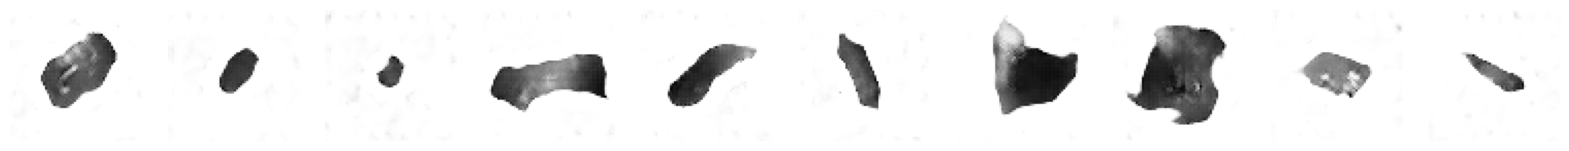

313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 274ms/step - d_acc: 0.9500 - d_fake_acc: 0.9504 - d_loss: -0.1946 - d_real_acc: 0.9495 - g_acc: 0.0496 - g_loss: 8.4908
Epoch 35/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_acc: 0.9138 - d_fake_acc: 0.9410 - d_loss: 0.3442 - d_real_acc: 0.8867 - g_acc: 0.0590 - g_loss: 9.3387
Saved to generated_img_034.png


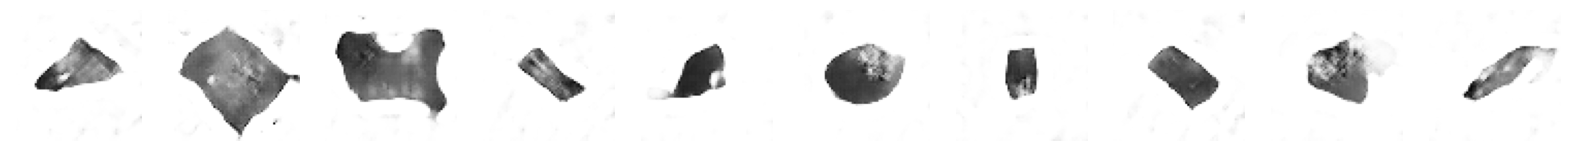

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 273ms/step - d_acc: 0.9139 - d_fake_acc: 0.9410 - d_loss: 0.3432 - d_real_acc: 0.8868 - g_acc: 0.0590 - g_loss: 9.3373
Epoch 36/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - d_acc: 0.9515 - d_fake_acc: 0.9514 - d_loss: -0.2596 - d_real_acc: 0.9517 - g_acc: 0.0486 - g_loss: 9.6216
Saved to generated_img_035.png


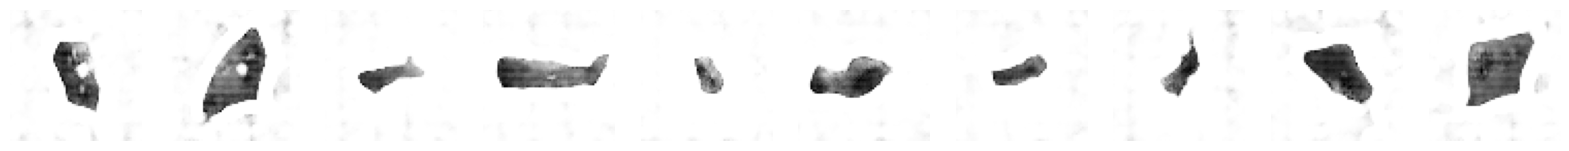

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 271ms/step - d_acc: 0.9514 - d_fake_acc: 0.9513 - d_loss: -0.2590 - d_real_acc: 0.9516 - g_acc: 0.0487 - g_loss: 9.6202
Epoch 37/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - d_acc: 0.9282 - d_fake_acc: 0.9282 - d_loss: -0.1101 - d_real_acc: 0.9283 - g_acc: 0.0718 - g_loss: 7.9743
Saved to generated_img_036.png


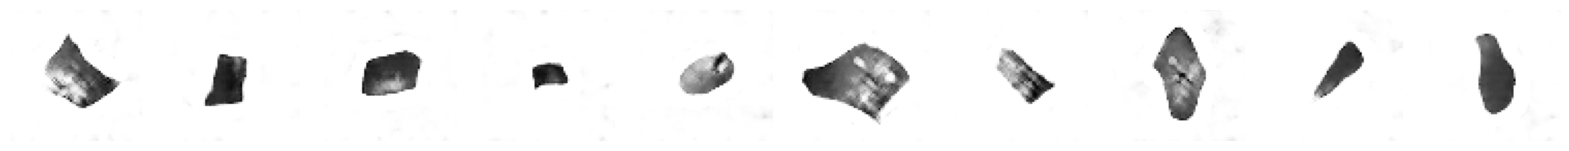

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 270ms/step - d_acc: 0.9283 - d_fake_acc: 0.9283 - d_loss: -0.1106 - d_real_acc: 0.9284 - g_acc: 0.0717 - g_loss: 7.9777
Epoch 38/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - d_acc: 0.9305 - d_fake_acc: 0.9321 - d_loss: -0.1078 - d_real_acc: 0.9290 - g_acc: 0.0679 - g_loss: 8.9781
Saved to generated_img_037.png


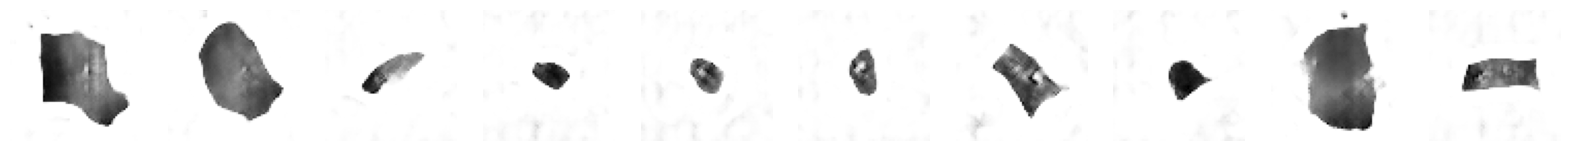

313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 274ms/step - d_acc: 0.9305 - d_fake_acc: 0.9321 - d_loss: -0.1075 - d_real_acc: 0.9289 - g_acc: 0.0679 - g_loss: 8.9797
Epoch 39/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - d_acc: 0.9458 - d_fake_acc: 0.9492 - d_loss: -0.2069 - d_real_acc: 0.9424 - g_acc: 0.0508 - g_loss: 8.7112
Saved to generated_img_038.png


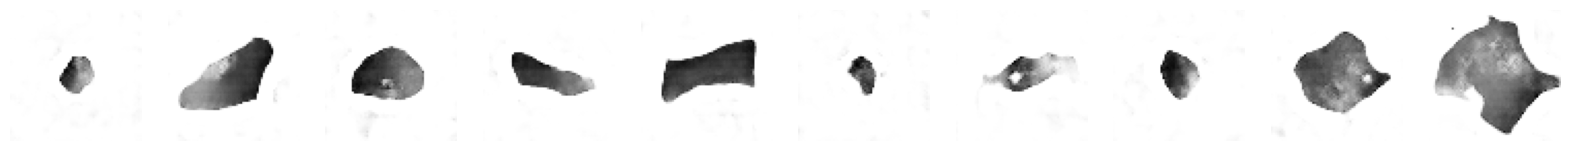

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 277ms/step - d_acc: 0.9458 - d_fake_acc: 0.9492 - d_loss: -0.2065 - d_real_acc: 0.9424 - g_acc: 0.0508 - g_loss: 8.7124
Epoch 40/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - d_acc: 0.9492 - d_fake_acc: 0.9494 - d_loss: -0.2045 - d_real_acc: 0.9489 - g_acc: 0.0506 - g_loss: 8.5652
Saved to generated_img_039.png


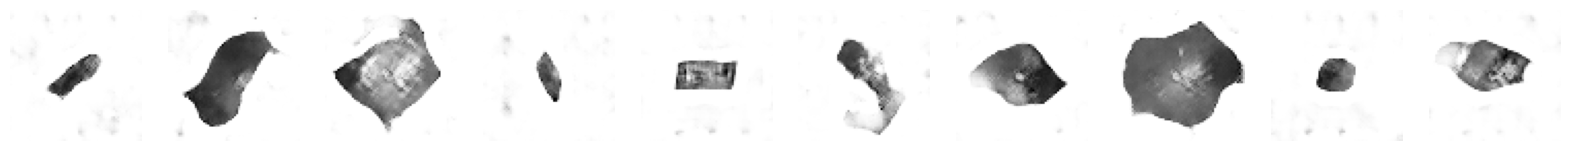

313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 283ms/step - d_acc: 0.9491 - d_fake_acc: 0.9494 - d_loss: -0.2042 - d_real_acc: 0.9488 - g_acc: 0.0506 - g_loss: 8.5657
Epoch 41/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - d_acc: 0.9696 - d_fake_acc: 0.9706 - d_loss: -0.3693 - d_real_acc: 0.9686 - g_acc: 0.0294 - g_loss: 10.1896
Saved to generated_img_040.png


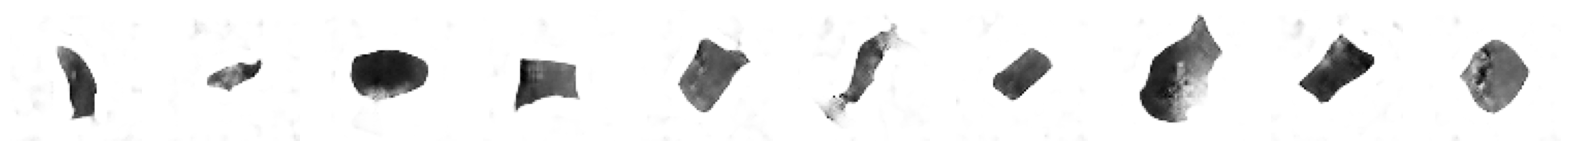

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 283ms/step - d_acc: 0.9696 - d_fake_acc: 0.9706 - d_loss: -0.3690 - d_real_acc: 0.9686 - g_acc: 0.0294 - g_loss: 10.1887
Epoch 42/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - d_acc: 0.9570 - d_fake_acc: 0.9570 - d_loss: -0.2835 - d_real_acc: 0.9571 - g_acc: 0.0430 - g_loss: 9.3738
Saved to generated_img_041.png


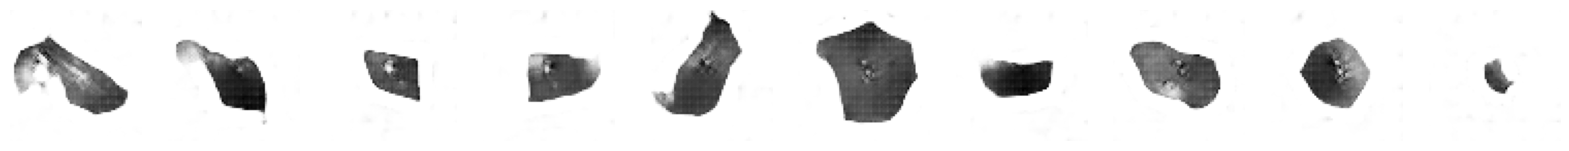

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 282ms/step - d_acc: 0.9570 - d_fake_acc: 0.9570 - d_loss: -0.2833 - d_real_acc: 0.9570 - g_acc: 0.0430 - g_loss: 9.3731
Epoch 43/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - d_acc: 0.9634 - d_fake_acc: 0.9635 - d_loss: -0.3810 - d_real_acc: 0.9633 - g_acc: 0.0365 - g_loss: 10.9153
Saved to generated_img_042.png


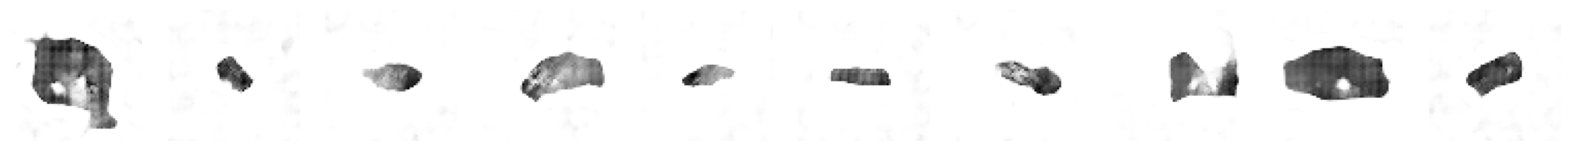

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 286ms/step - d_acc: 0.9634 - d_fake_acc: 0.9635 - d_loss: -0.3809 - d_real_acc: 0.9633 - g_acc: 0.0365 - g_loss: 10.9151
Epoch 44/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - d_acc: 0.9493 - d_fake_acc: 0.9491 - d_loss: -0.2333 - d_real_acc: 0.9496 - g_acc: 0.0509 - g_loss: 8.8252
Saved to generated_img_043.png


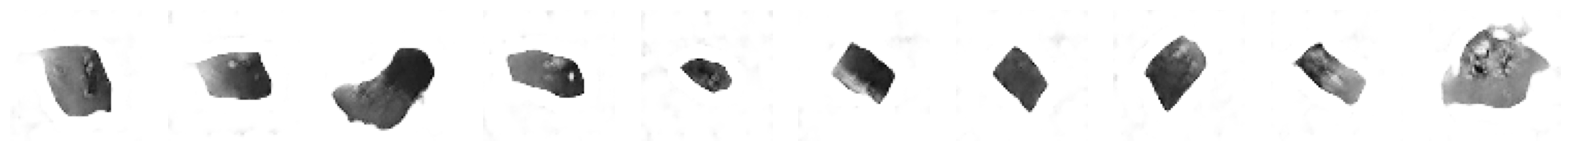

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 284ms/step - d_acc: 0.9493 - d_fake_acc: 0.9491 - d_loss: -0.2333 - d_real_acc: 0.9496 - g_acc: 0.0509 - g_loss: 8.8283
Epoch 45/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - d_acc: 0.9621 - d_fake_acc: 0.9622 - d_loss: -0.3516 - d_real_acc: 0.9619 - g_acc: 0.0378 - g_loss: 10.7250
Saved to generated_img_044.png


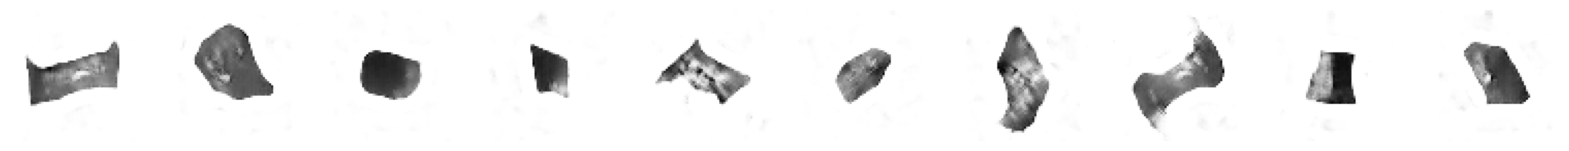

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 285ms/step - d_acc: 0.9620 - d_fake_acc: 0.9622 - d_loss: -0.3513 - d_real_acc: 0.9619 - g_acc: 0.0378 - g_loss: 10.7239
Epoch 46/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - d_acc: 0.9584 - d_fake_acc: 0.9582 - d_loss: -0.3169 - d_real_acc: 0.9587 - g_acc: 0.0418 - g_loss: 10.3482
Saved to generated_img_045.png


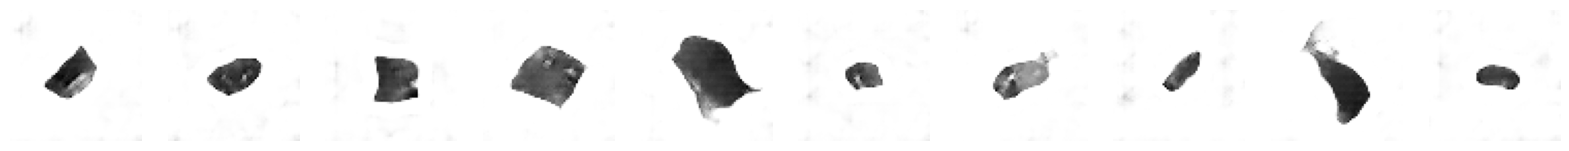

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 287ms/step - d_acc: 0.9584 - d_fake_acc: 0.9582 - d_loss: -0.3169 - d_real_acc: 0.9587 - g_acc: 0.0418 - g_loss: 10.3482
Epoch 47/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - d_acc: 0.9687 - d_fake_acc: 0.9690 - d_loss: -0.4010 - d_real_acc: 0.9683 - g_acc: 0.0310 - g_loss: 11.1607
Saved to generated_img_046.png


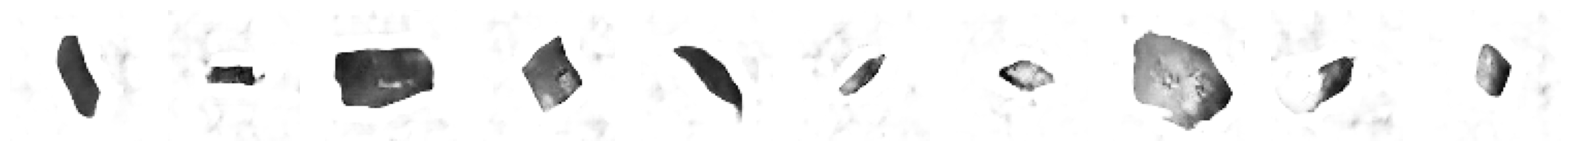

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 288ms/step - d_acc: 0.9686 - d_fake_acc: 0.9690 - d_loss: -0.4009 - d_real_acc: 0.9683 - g_acc: 0.0310 - g_loss: 11.1601
Epoch 48/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - d_acc: 0.9780 - d_fake_acc: 0.9757 - d_loss: -0.4899 - d_real_acc: 0.9803 - g_acc: 0.0243 - g_loss: 11.6039
Saved to generated_img_047.png


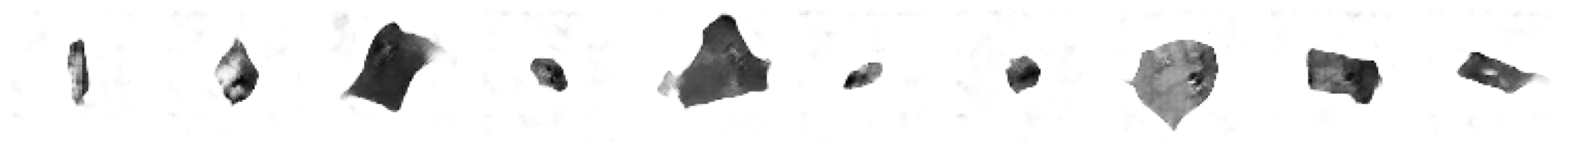

313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 291ms/step - d_acc: 0.9779 - d_fake_acc: 0.9756 - d_loss: -0.4894 - d_real_acc: 0.9803 - g_acc: 0.0244 - g_loss: 11.6024
Epoch 49/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - d_acc: 0.9417 - d_fake_acc: 0.9420 - d_loss: -0.2130 - d_real_acc: 0.9413 - g_acc: 0.0580 - g_loss: 10.3467
Saved to generated_img_048.png


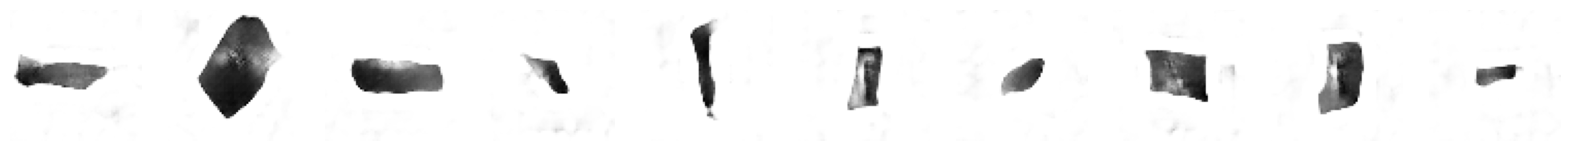

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 288ms/step - d_acc: 0.9417 - d_fake_acc: 0.9421 - d_loss: -0.2135 - d_real_acc: 0.9414 - g_acc: 0.0579 - g_loss: 10.3489
Epoch 50/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - d_acc: 0.9565 - d_fake_acc: 0.9625 - d_loss: -0.2563 - d_real_acc: 0.9504 - g_acc: 0.0375 - g_loss: 11.0354
Saved to generated_img_049.png


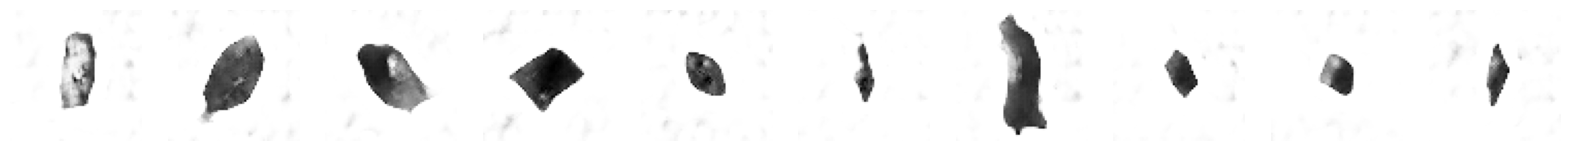

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 286ms/step - d_acc: 0.9565 - d_fake_acc: 0.9625 - d_loss: -0.2566 - d_real_acc: 0.9505 - g_acc: 0.0375 - g_loss: 11.0358
Epoch 51/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - d_acc: 0.9647 - d_fake_acc: 0.9656 - d_loss: -0.4139 - d_real_acc: 0.9639 - g_acc: 0.0344 - g_loss: 11.3550
Saved to generated_img_050.png


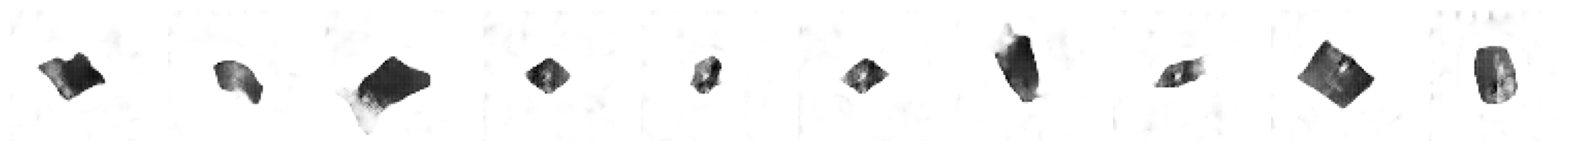

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 287ms/step - d_acc: 0.9647 - d_fake_acc: 0.9656 - d_loss: -0.4140 - d_real_acc: 0.9639 - g_acc: 0.0344 - g_loss: 11.3561
Epoch 52/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - d_acc: 0.9999 - d_fake_acc: 0.9999 - d_loss: -0.7957 - d_real_acc: 0.9999 - g_acc: 9.3155e-05 - g_loss: 16.0295
Saved to generated_img_051.png


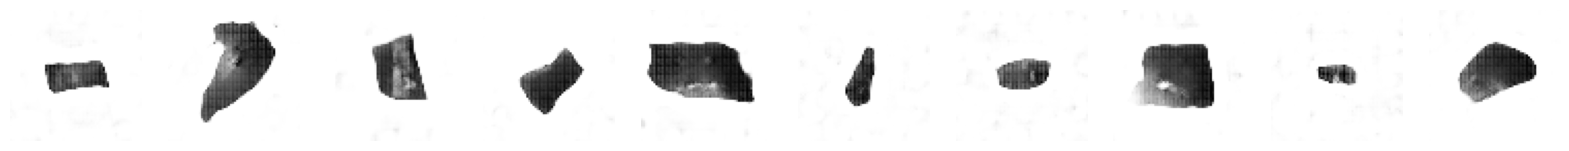

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 284ms/step - d_acc: 0.9999 - d_fake_acc: 0.9999 - d_loss: -0.7957 - d_real_acc: 0.9999 - g_acc: 9.2938e-05 - g_loss: 16.0297
Epoch 53/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - d_acc: 0.9789 - d_fake_acc: 0.9792 - d_loss: -0.6039 - d_real_acc: 0.9787 - g_acc: 0.0208 - g_loss: 14.5518
Saved to generated_img_052.png


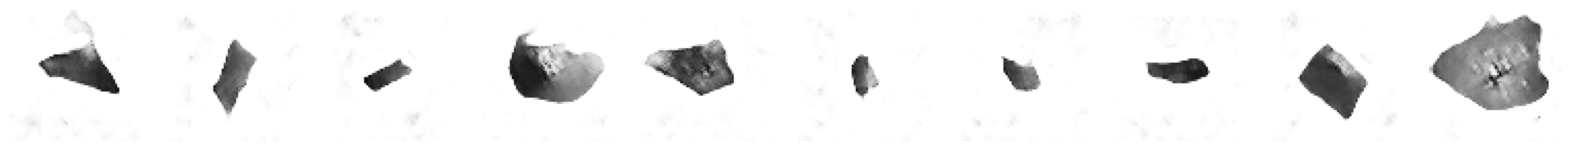

313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 290ms/step - d_acc: 0.9788 - d_fake_acc: 0.9791 - d_loss: -0.6030 - d_real_acc: 0.9786 - g_acc: 0.0209 - g_loss: 14.5445
Epoch 54/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - d_acc: 0.9672 - d_fake_acc: 0.9711 - d_loss: -0.4496 - d_real_acc: 0.9633 - g_acc: 0.0289 - g_loss: 11.5198
Saved to generated_img_053.png


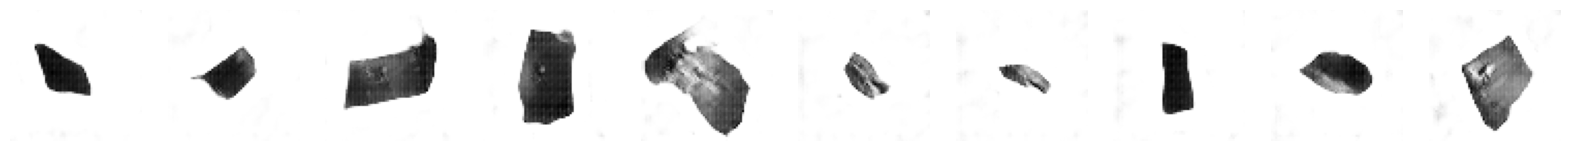

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 288ms/step - d_acc: 0.9672 - d_fake_acc: 0.9711 - d_loss: -0.4499 - d_real_acc: 0.9633 - g_acc: 0.0289 - g_loss: 11.5228
Epoch 55/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - d_acc: 0.9811 - d_fake_acc: 0.9815 - d_loss: -0.6275 - d_real_acc: 0.9808 - g_acc: 0.0185 - g_loss: 14.5730
Saved to generated_img_054.png


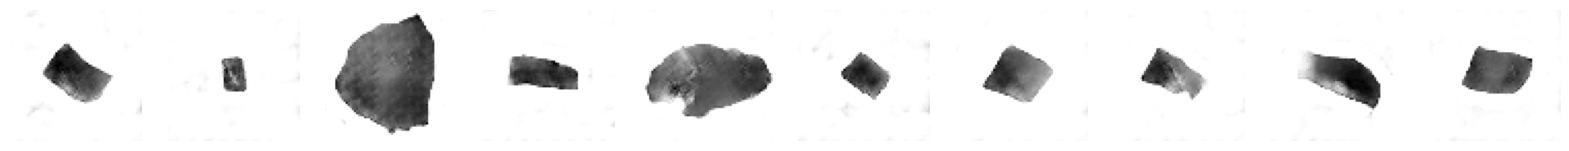

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 287ms/step - d_acc: 0.9810 - d_fake_acc: 0.9814 - d_loss: -0.6266 - d_real_acc: 0.9807 - g_acc: 0.0186 - g_loss: 14.5651
Epoch 56/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - d_acc: 0.9838 - d_fake_acc: 0.9844 - d_loss: -0.5054 - d_real_acc: 0.9832 - g_acc: 0.0156 - g_loss: 11.5548
Saved to generated_img_055.png


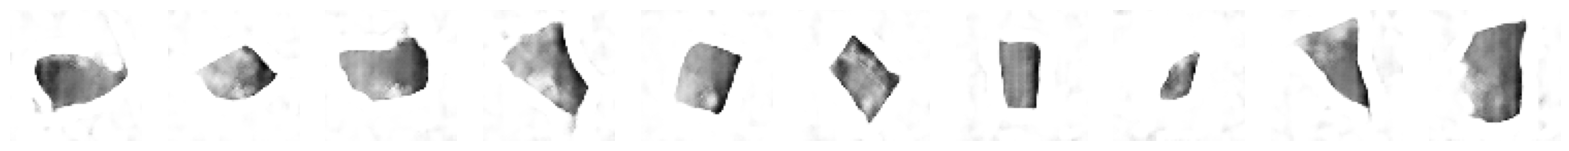

313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 289ms/step - d_acc: 0.9837 - d_fake_acc: 0.9843 - d_loss: -0.5049 - d_real_acc: 0.9831 - g_acc: 0.0157 - g_loss: 11.5552
Epoch 57/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - d_acc: 0.9533 - d_fake_acc: 0.9558 - d_loss: -0.2228 - d_real_acc: 0.9507 - g_acc: 0.0442 - g_loss: 9.6010
Saved to generated_img_056.png


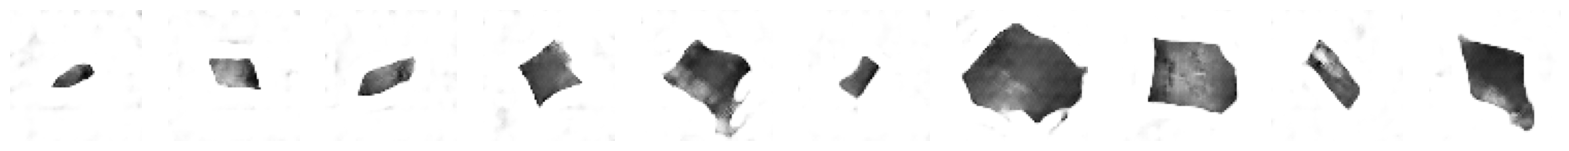

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 286ms/step - d_acc: 0.9533 - d_fake_acc: 0.9558 - d_loss: -0.2226 - d_real_acc: 0.9507 - g_acc: 0.0442 - g_loss: 9.6027
Epoch 58/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - d_acc: 0.9838 - d_fake_acc: 0.9841 - d_loss: -0.5011 - d_real_acc: 0.9835 - g_acc: 0.0159 - g_loss: 11.3465
Saved to generated_img_057.png


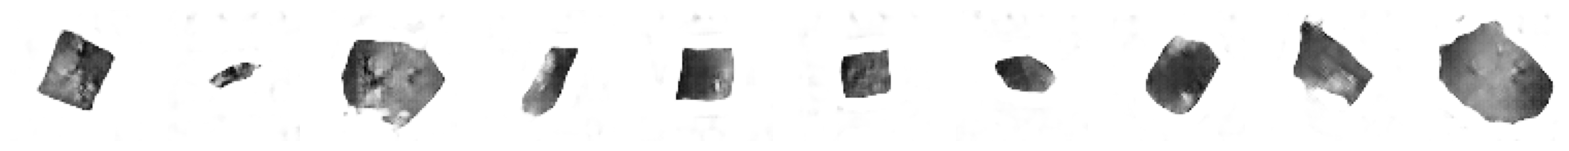

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 288ms/step - d_acc: 0.9838 - d_fake_acc: 0.9841 - d_loss: -0.5011 - d_real_acc: 0.9835 - g_acc: 0.0159 - g_loss: 11.3480
Epoch 59/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - d_acc: 0.9574 - d_fake_acc: 0.9632 - d_loss: -0.3168 - d_real_acc: 0.9515 - g_acc: 0.0368 - g_loss: 12.2153
Saved to generated_img_058.png


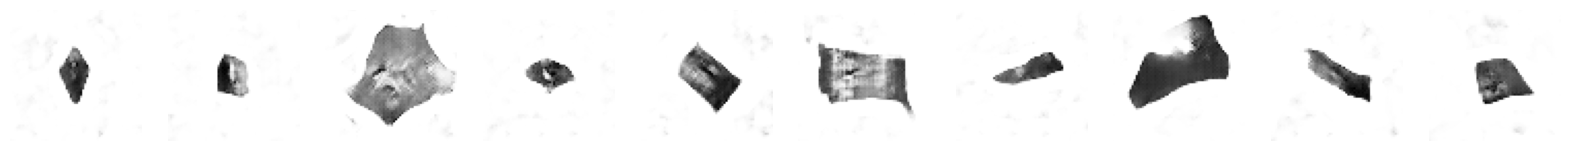

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 285ms/step - d_acc: 0.9573 - d_fake_acc: 0.9632 - d_loss: -0.3166 - d_real_acc: 0.9515 - g_acc: 0.0368 - g_loss: 12.2132
Epoch 60/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - d_acc: 0.9573 - d_fake_acc: 0.9595 - d_loss: -0.3397 - d_real_acc: 0.9551 - g_acc: 0.0405 - g_loss: 11.3510
Saved to generated_img_059.png


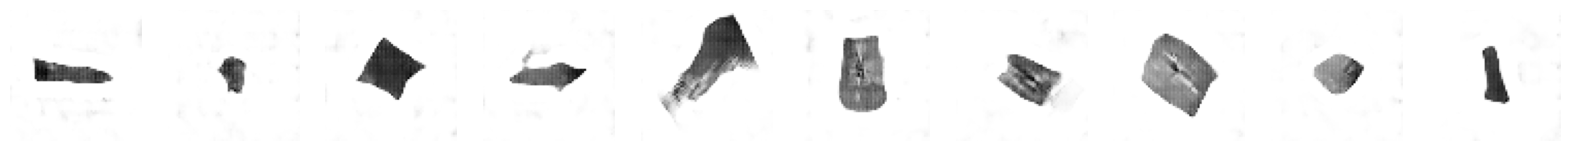

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 288ms/step - d_acc: 0.9573 - d_fake_acc: 0.9595 - d_loss: -0.3400 - d_real_acc: 0.9551 - g_acc: 0.0405 - g_loss: 11.3524
Epoch 61/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - d_acc: 0.9728 - d_fake_acc: 0.9735 - d_loss: -0.4565 - d_real_acc: 0.9720 - g_acc: 0.0265 - g_loss: 12.4280
Saved to generated_img_060.png


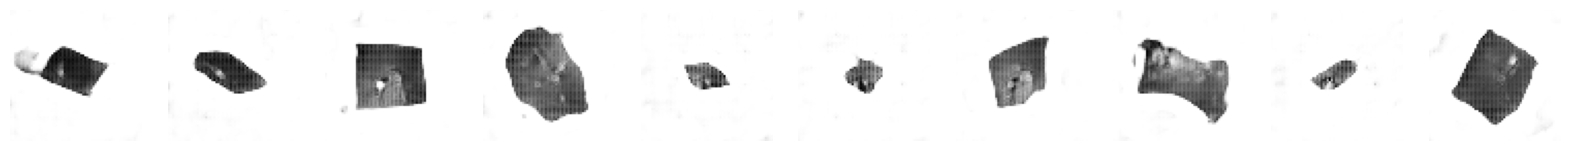

313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 292ms/step - d_acc: 0.9728 - d_fake_acc: 0.9736 - d_loss: -0.4570 - d_real_acc: 0.9721 - g_acc: 0.0264 - g_loss: 12.4324
Epoch 62/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8001 - d_real_acc: 1.0000 - g_acc: 3.5926e-05 - g_loss: 16.0886
Saved to generated_img_061.png


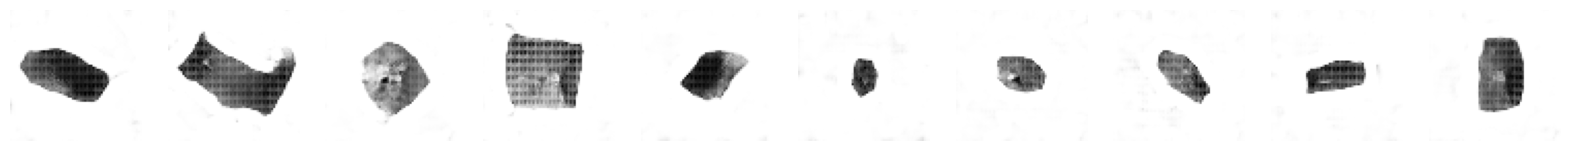

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 293ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8001 - d_real_acc: 1.0000 - g_acc: 3.6210e-05 - g_loss: 16.0884
Epoch 63/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8005 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1166
Saved to generated_img_062.png


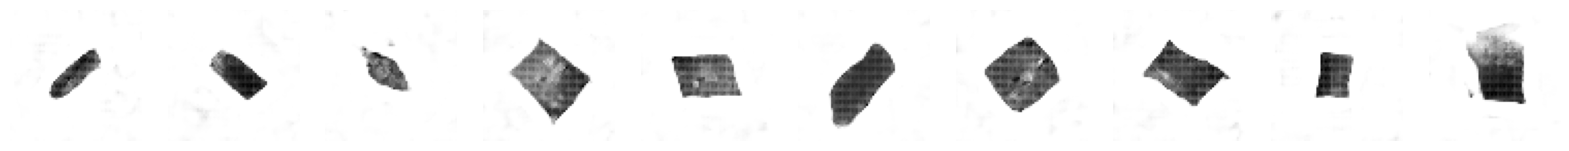

313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 291ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8005 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1166
Epoch 64/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - d_acc: 0.9211 - d_fake_acc: 0.9236 - d_loss: 0.0530 - d_real_acc: 0.9187 - g_acc: 0.0764 - g_loss: 12.5584
Saved to generated_img_063.png


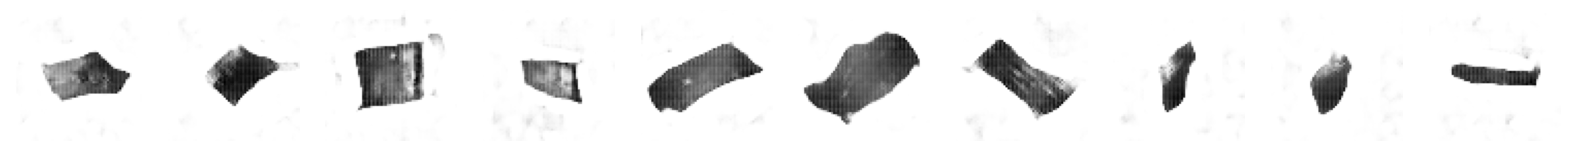

313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 297ms/step - d_acc: 0.9212 - d_fake_acc: 0.9236 - d_loss: 0.0527 - d_real_acc: 0.9187 - g_acc: 0.0764 - g_loss: 12.5569
Epoch 65/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - d_acc: 0.9836 - d_fake_acc: 0.9849 - d_loss: -0.6038 - d_real_acc: 0.9823 - g_acc: 0.0151 - g_loss: 13.9304
Saved to generated_img_064.png


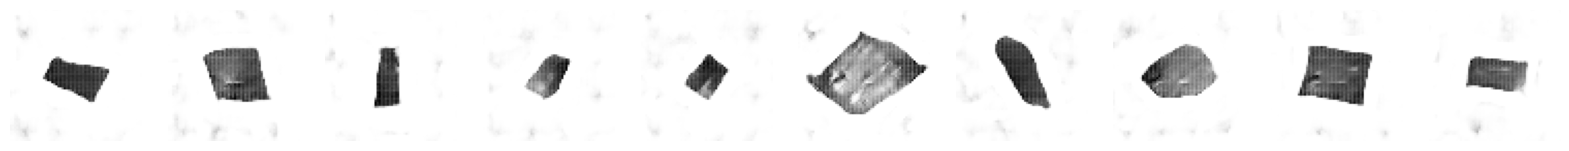

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 293ms/step - d_acc: 0.9836 - d_fake_acc: 0.9850 - d_loss: -0.6041 - d_real_acc: 0.9823 - g_acc: 0.0150 - g_loss: 13.9329
Epoch 66/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8007 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to generated_img_065.png


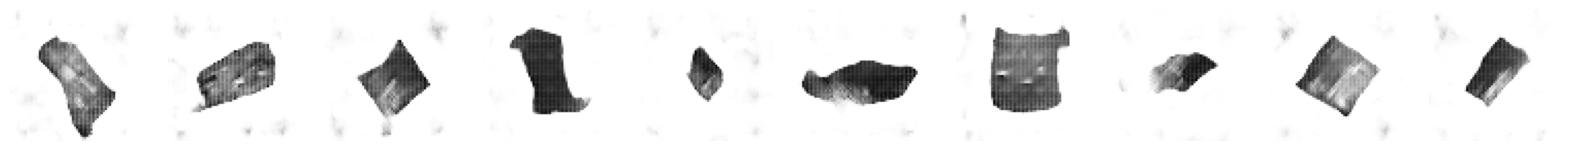

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 293ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8007 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Epoch 67/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8030 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1171
Saved to generated_img_066.png


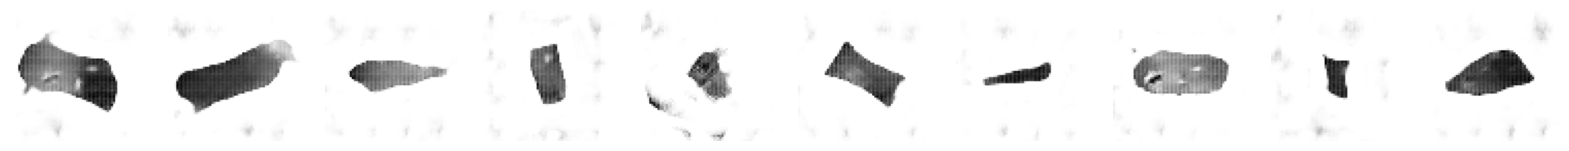

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 294ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8030 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1171
Epoch 68/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8044 - d_real_acc: 1.0000 - g_acc: 1.4648e-05 - g_loss: 16.1171
Saved to generated_img_067.png


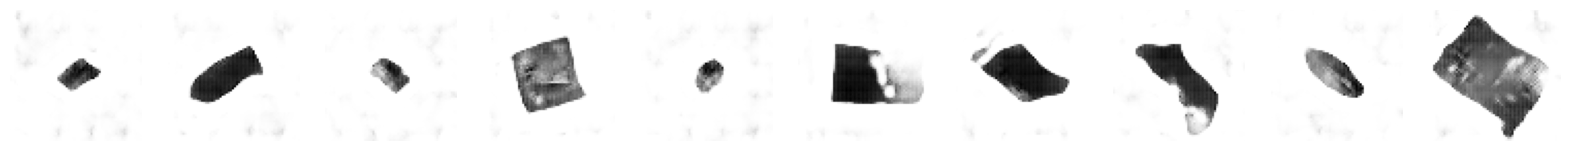

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 298ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8042 - d_real_acc: 1.0000 - g_acc: 1.9458e-05 - g_loss: 16.1169
Epoch 69/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - d_acc: 0.8099 - d_fake_acc: 0.8351 - d_loss: 1.1679 - d_real_acc: 0.7847 - g_acc: 0.1649 - g_loss: 9.0282
Saved to generated_img_068.png


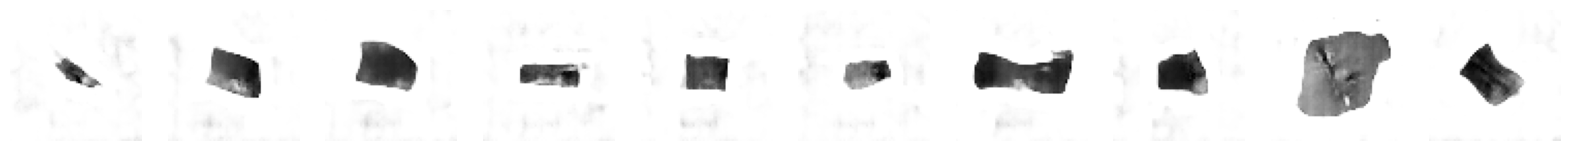

313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 304ms/step - d_acc: 0.8102 - d_fake_acc: 0.8353 - d_loss: 1.1648 - d_real_acc: 0.7850 - g_acc: 0.1647 - g_loss: 9.0316
Epoch 70/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - d_acc: 0.9642 - d_fake_acc: 0.9642 - d_loss: -0.4726 - d_real_acc: 0.9642 - g_acc: 0.0358 - g_loss: 12.4903
Saved to generated_img_069.png


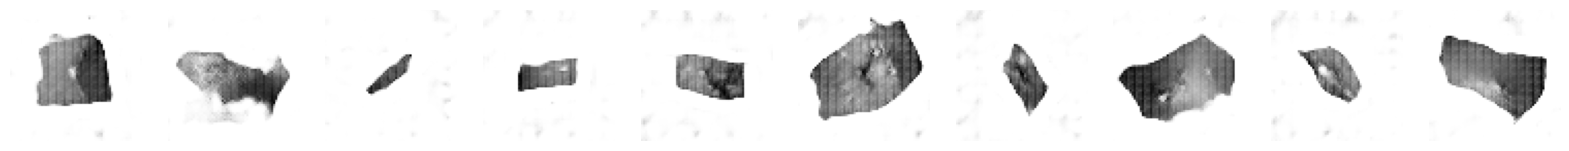

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 307ms/step - d_acc: 0.9643 - d_fake_acc: 0.9643 - d_loss: -0.4730 - d_real_acc: 0.9643 - g_acc: 0.0357 - g_loss: 12.4948
Epoch 71/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - d_acc: 0.9995 - d_fake_acc: 0.9995 - d_loss: -0.7846 - d_real_acc: 0.9995 - g_acc: 4.8173e-04 - g_loss: 15.8089
Saved to generated_img_070.png


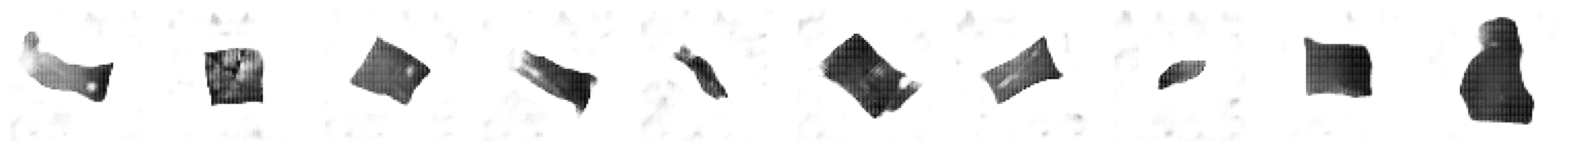

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 307ms/step - d_acc: 0.9995 - d_fake_acc: 0.9995 - d_loss: -0.7846 - d_real_acc: 0.9995 - g_acc: 4.8107e-04 - g_loss: 15.8093
Epoch 72/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8003 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to generated_img_071.png


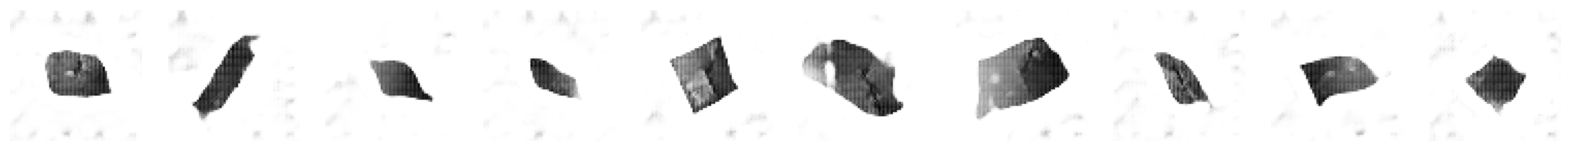

313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8003 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 73/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7985 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to generated_img_072.png


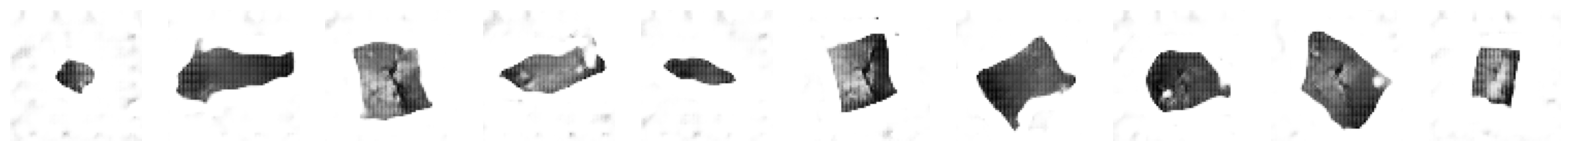

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 305ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7986 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 74/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8024 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to generated_img_073.png


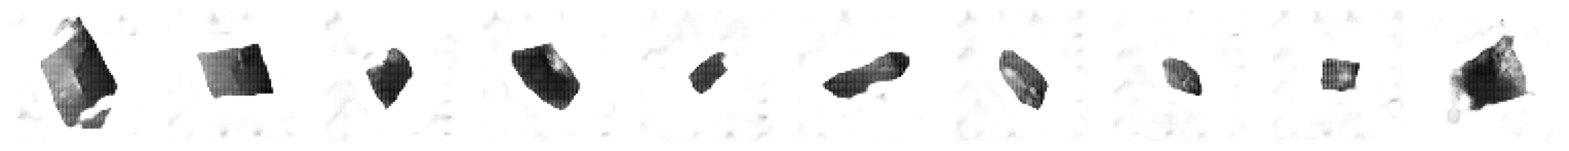

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 302ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8025 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Epoch 75/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8027 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1178
Saved to generated_img_074.png


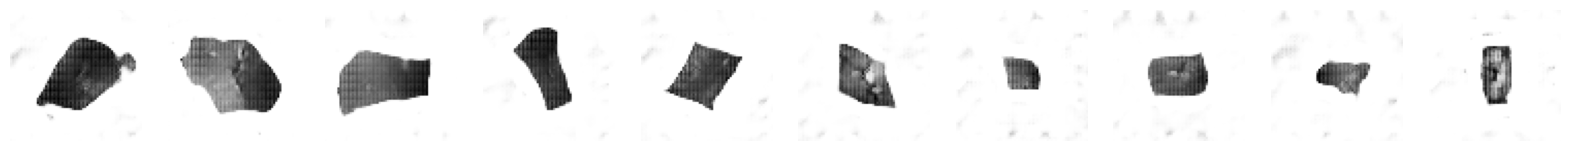

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 304ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8027 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1178
Epoch 76/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8006 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to generated_img_075.png


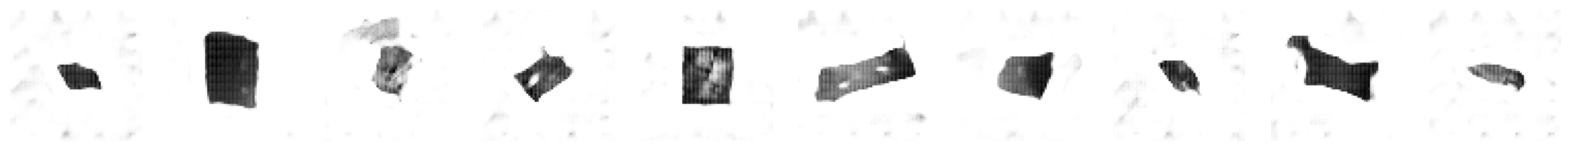

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 302ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8006 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Epoch 77/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8015 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Saved to generated_img_076.png


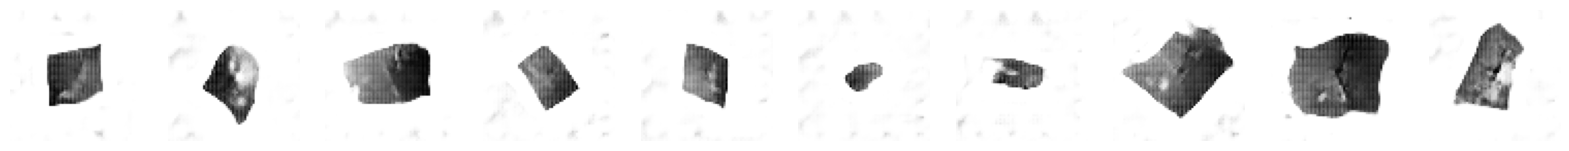

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 305ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8016 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Epoch 78/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8022 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1127
Saved to generated_img_077.png


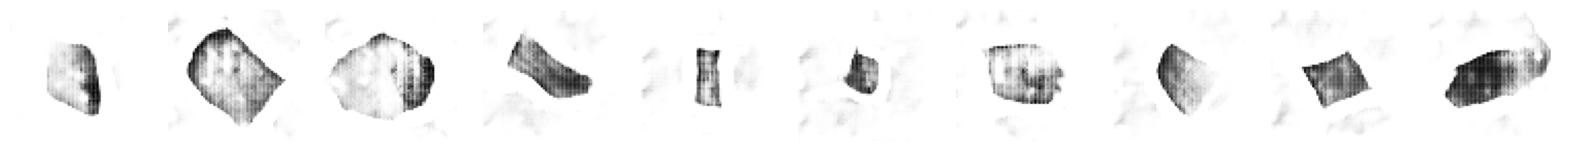

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 304ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8022 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1126
Epoch 79/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8019 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to generated_img_078.png


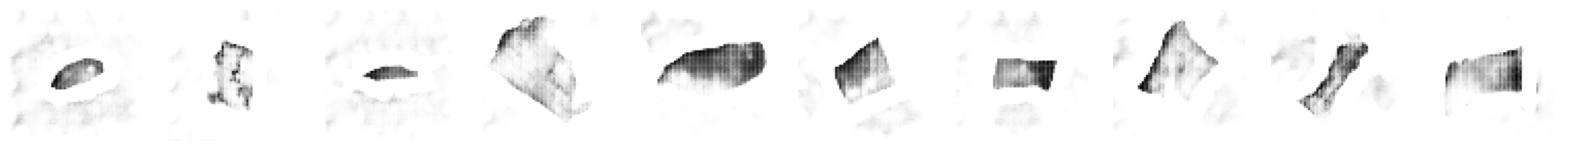

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 307ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8019 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Epoch 80/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8048 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1174
Saved to generated_img_079.png


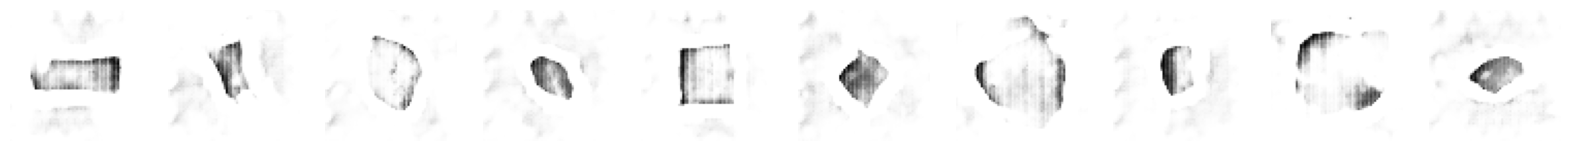

313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 304ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8048 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1174
Epoch 81/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - d_acc: 0.9997 - d_fake_acc: 0.9999 - d_loss: -0.7965 - d_real_acc: 0.9996 - g_acc: 8.5459e-05 - g_loss: 16.1020
Saved to generated_img_080.png


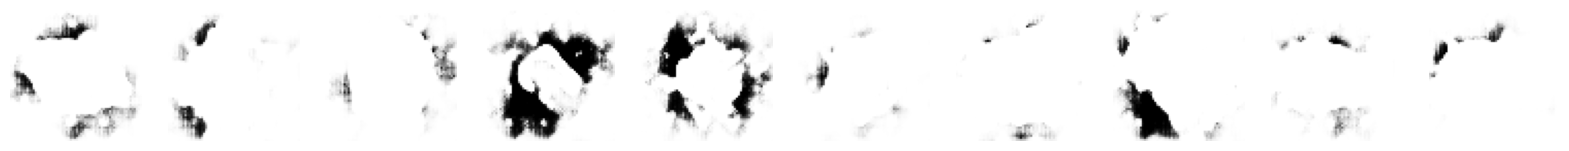

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 306ms/step - d_acc: 0.9997 - d_fake_acc: 0.9999 - d_loss: -0.7964 - d_real_acc: 0.9996 - g_acc: 8.7655e-05 - g_loss: 16.1017
Epoch 82/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - d_acc: 0.9999 - d_fake_acc: 0.9999 - d_loss: -0.8019 - d_real_acc: 1.0000 - g_acc: 1.2997e-04 - g_loss: 16.0686
Saved to generated_img_081.png


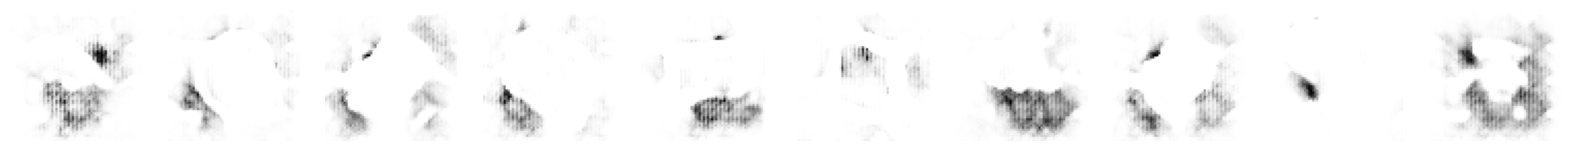

313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 313ms/step - d_acc: 0.9999 - d_fake_acc: 0.9999 - d_loss: -0.8019 - d_real_acc: 1.0000 - g_acc: 1.2980e-04 - g_loss: 16.0685
Epoch 83/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7986 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Saved to generated_img_082.png


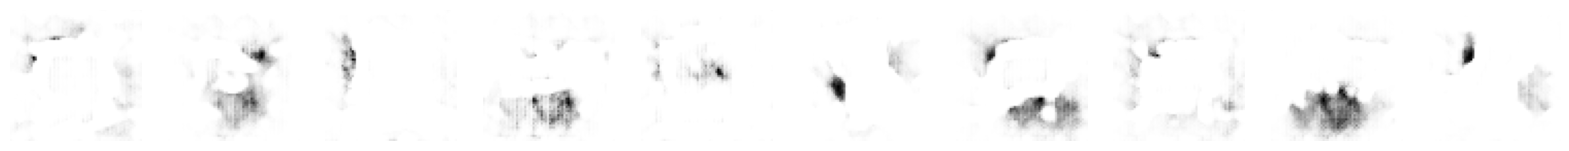

313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 307ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7986 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Epoch 84/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7973 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1113
Saved to generated_img_083.png


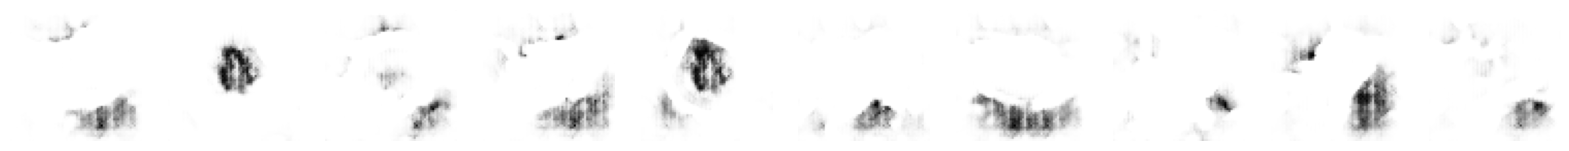

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 311ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7973 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1113
Epoch 85/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8017 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1139
Saved to generated_img_084.png


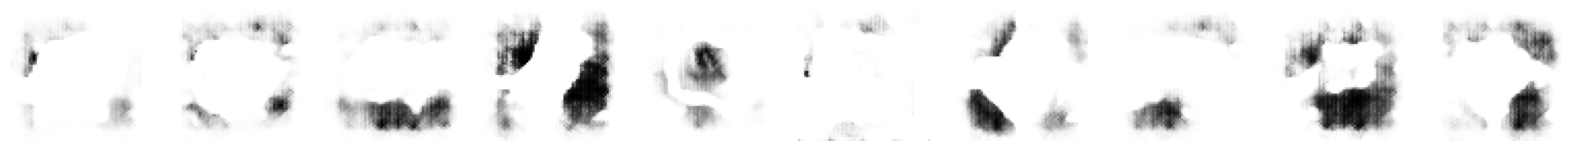

313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 310ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8017 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1139
Epoch 86/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7999 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1141
Saved to generated_img_085.png


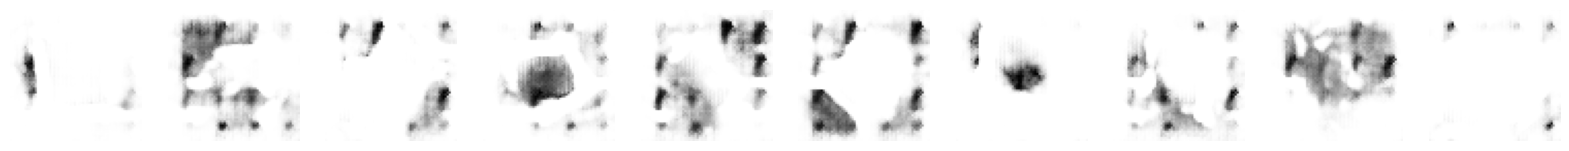

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 311ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7999 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1140
Epoch 87/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8011 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1092
Saved to generated_img_086.png


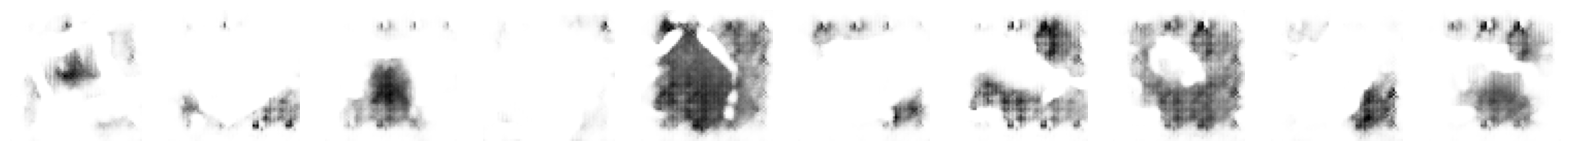

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 313ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8011 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1092
Epoch 88/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8040 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1133
Saved to generated_img_087.png


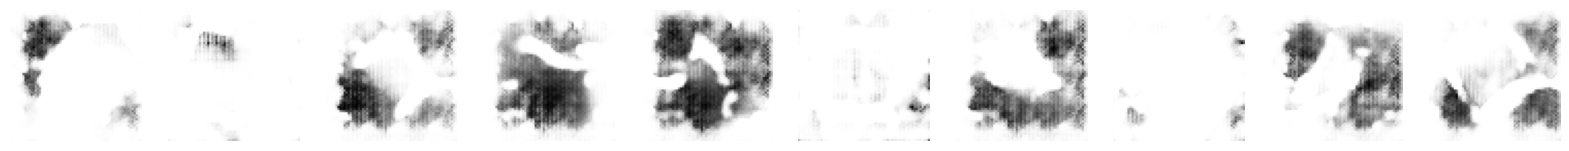

313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 318ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8040 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1133
Epoch 89/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7999 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to generated_img_088.png


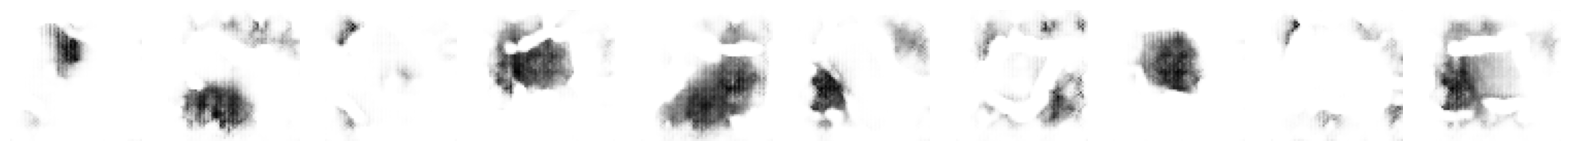

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 317ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7999 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 90/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7978 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1178
Saved to generated_img_089.png


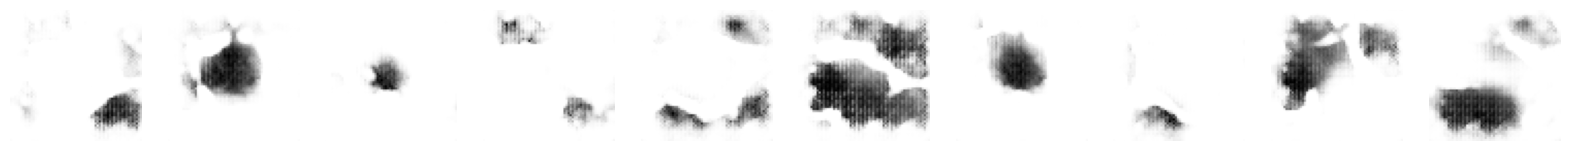

313/313 ━━━━━━━━━━━━━━━━━━━━ 99s 317ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7978 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1178
Epoch 91/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8040 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Saved to generated_img_090.png


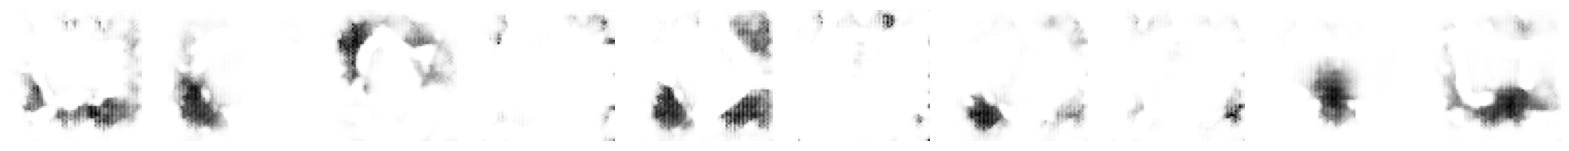

313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 314ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8040 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181
Epoch 92/300
143/313 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7974 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181

In [ ]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM)
    ]
)

## Generate new images

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle('Generated Images', fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap='gray_r')
        axs[i, j].axis('off')
        cnt += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle('Closest Images in the Training Set', fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap='gray_r')
        axs[i, j].axis('off')
        cnt += 1

plt.show()